### Detección y Conteo de Vehículos

Este proyecto implementa un algoritmo capaz de detectar y contar vehículos que circulan en una carretera a partir de una secuencia de video de entrada, utilizando técnicas de detección de movimiento, análisis de blobs y operaciones morfológicas.



## Objetivo 

Este proyecto desarrolla un sistema de análisis de tráfico que puede identificar y contar automáticamente los vehículos que aparecen en una secuencia de video. El algoritmo procesa una secuencia de frames para detectar objetos en movimiento mediante técnicas de visión por computadora.



## Configuración del Entorno

Se configuran las bibliotecas necesarias para el procesamiento de secuencias de video y detección de objetos.



In [73]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import data, io, filters,measure
from skimage.color import rgb2gray
from skimage.feature import blob_doh
from skimage.filters import threshold_otsu
from skimage.morphology import opening, closing, erosion, dilation, disk

### Configuración de Directorio

Se configura el directorio base para la carga de archivos. Si se ejecuta en Google Colab, se debe configurar la ruta correspondiente en el sistema de archivos de Google Drive.



In [ ]:
import importlib
import sys
from os.path import join

# Configuración de directorio base
# Si se ejecuta en Google Colab, descomentar y configurar la ruta correspondiente
google_colab = False

if google_colab:
    drive = importlib.import_module('google.colab.drive')
    drive.mount('/content/drive')
    sys.path.insert(0, '/content/drive/MyDrive/computer-vision/deteccion_conteo_vehiculos')
    dir_base = "/content/drive/MyDrive/computer-vision/deteccion_conteo_vehiculos"
else:
    dir_base = "./"

In [34]:
def mostrar_frames(video):
    """Muestra una secuencia de frames almacenada en una lista"""
    for frame in video:
        if (type(frame[0][0]) == np.bool_):
            io.imshow(frame.astype(float), cmap=plt.cm.gray)
        else:
            io.imshow(frame)
        io.show()

In [35]:
def mostrar_blobs(img, blobs):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)

    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color="red", linewidth=2, fill=False)
        ax.add_artist(c)

### Carga de Secuencia de Video

Se trabaja con una secuencia de imágenes en lugar de una única imagen. Para facilitar el manejo de estos datos, se utiliza `ImageCollection` de scikit-image, que permite cargar y procesar múltiples frames de manera eficiente.



In [36]:
video_rgb = io.ImageCollection(join(dir_base, 'highway/*.png'))
print(len(video_rgb))

10


Podemos acceder a la primera imagen accediendo directamente a la primera posición del array.



In [37]:
print(video_rgb[0].shape)

(354, 630, 3)


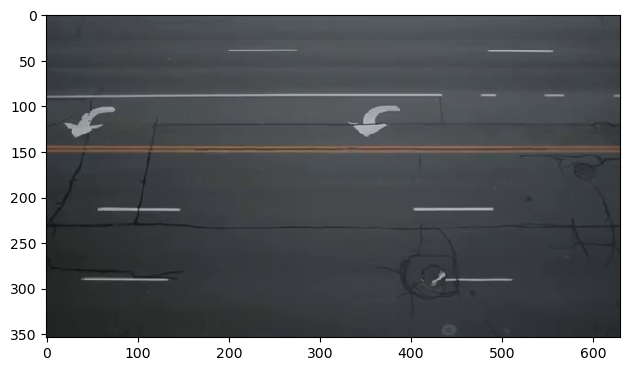

In [38]:
io.imshow(video_rgb[0])
io.show()

## Conversión a grises

El primer paso que vamos a dar es convertir a escala de grises cada uno de los frames de la secuencia a procesar:



In [39]:
def convierte_a_gris(video):
    '''
    Convierte la secuencia de entrada en RGB a una secuencia en escala de grises
    Recibe una lista de frames (vide) y devuelve una secuencia de frames de salida
    '''
    out = []
    
    # Recorremos cada frame del video
    for frame in video:
        # Convertimos a escala de grises usando rgb2gray
        frame_gray = rgb2gray(frame)
        
        # Añadimos el frame en escala de grises a la lista de salida
        out.append(frame_gray)
    
    return out

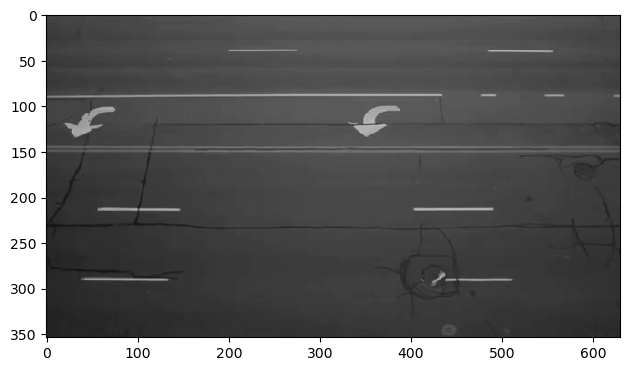

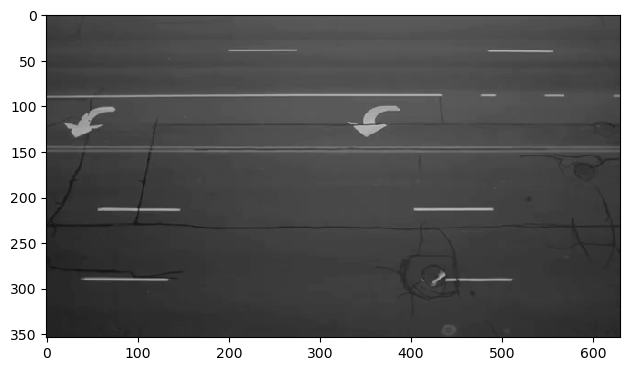

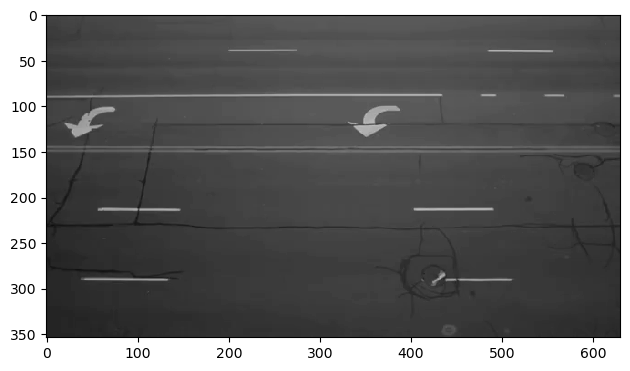

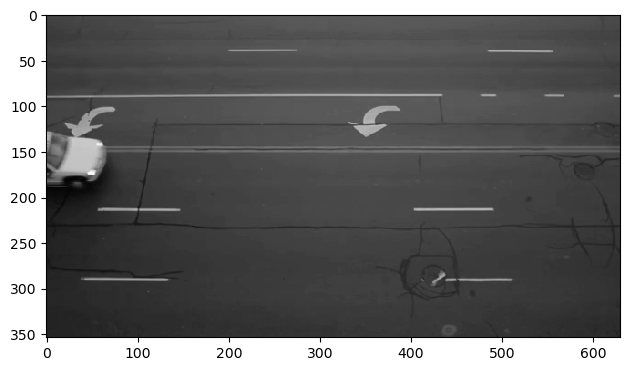

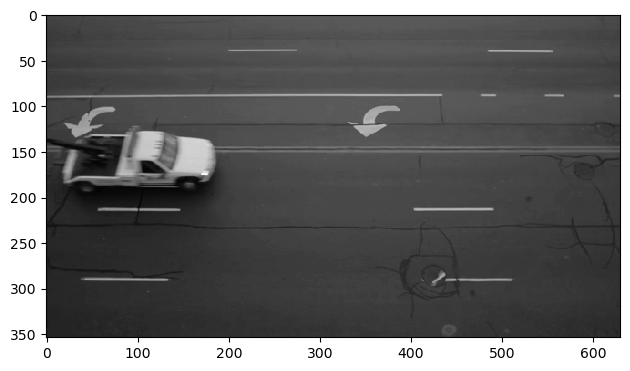

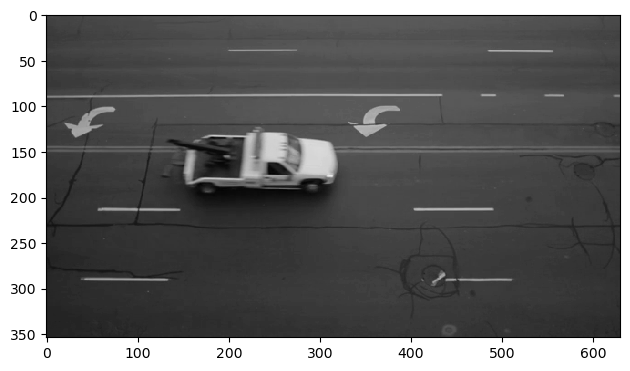

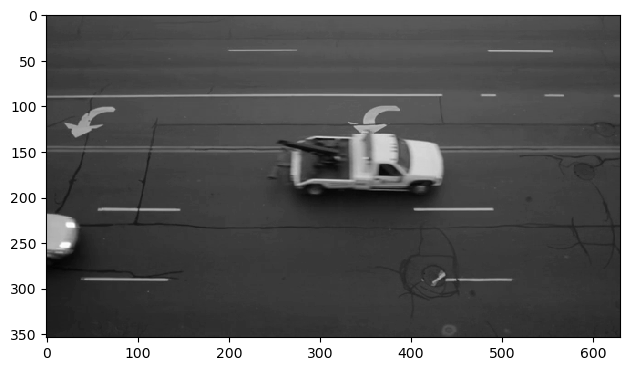

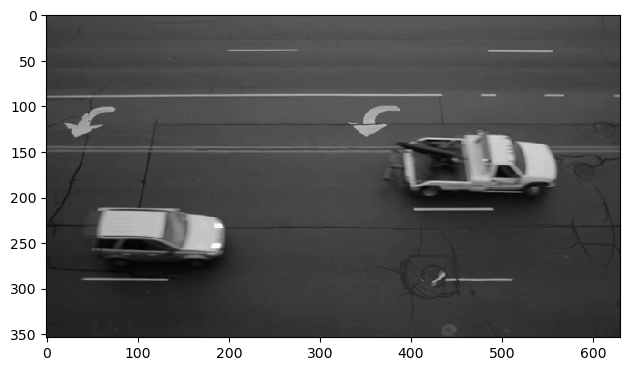

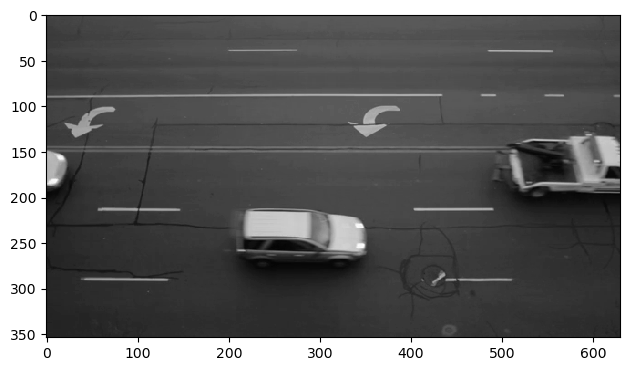

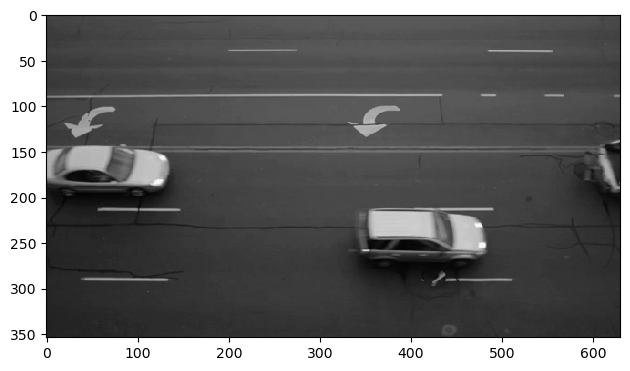

In [40]:
video_gris = convierte_a_gris(video_rgb)
mostrar_frames(video_gris)

## Análisis de diferencias

El siguiente paso que vamos a dar es realizar un análisis de diferencias que consiste en restar dos imágenes píxel a píxel para resaltar las diferencias entre ellas.$$IMG_{dif} = Abs(IMG_{n}- IMG_{n-1})$$En este caso el análisis de diferencias nos va a permitir identificar los píxels que han cambiado entre dos frames consecutivos (movimiento).



In [41]:
def calcula_diferencias(video):
    '''
    Realiza el análisis de diferencias entre frames consecutivos para el video de entrada
    Devuelve una secuencia de frames de salida
    '''
    out = []
    
    # Convertimos el video a escala de grises si no lo está
    video_gray = [rgb2gray(frame) if len(frame.shape) == 3 else frame for frame in video]
    
    # Calculamos la diferencia entre cada par de frames consecutivos
    for i in range(1, len(video_gray)):
        # Calculamos la diferencia absoluta entre frames
        diff = np.abs(video_gray[i] - video_gray[i-1])
        
        # Normalizamos la diferencia para que esté entre 0 y 1
        diff = diff / 255.0 if diff.max() > 1 else diff
        
        # Convertimos a tipo uint8 para que sea compatible con imágenes
        diff = (diff * 255).astype(np.uint8)
        
        out.append(diff)
    
    return out

In [42]:
video_dif = calcula_diferencias(video_gris)

/opt/anaconda3/envs/sh/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


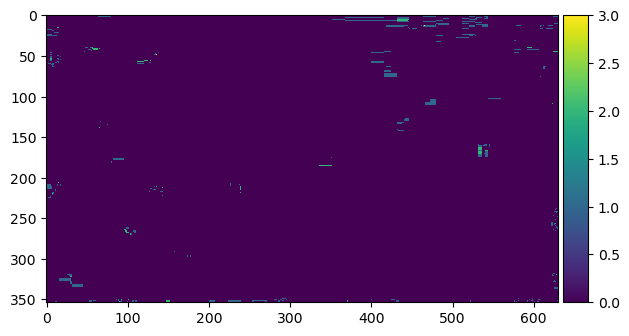

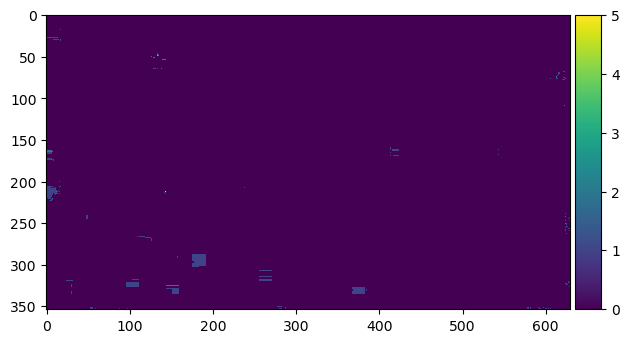

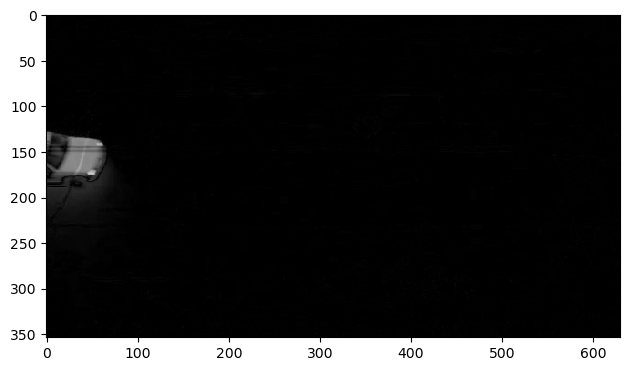

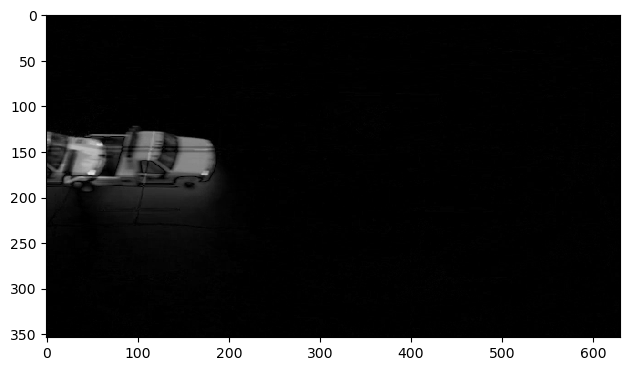

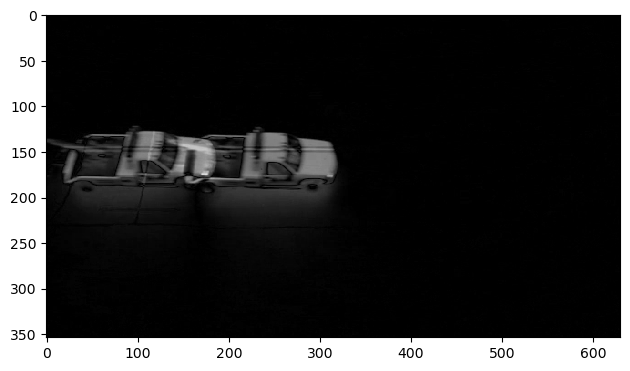

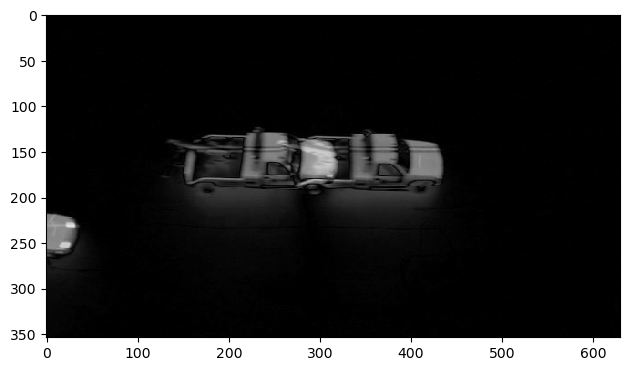

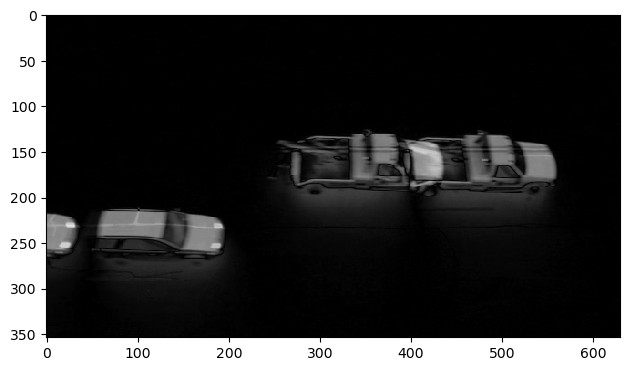

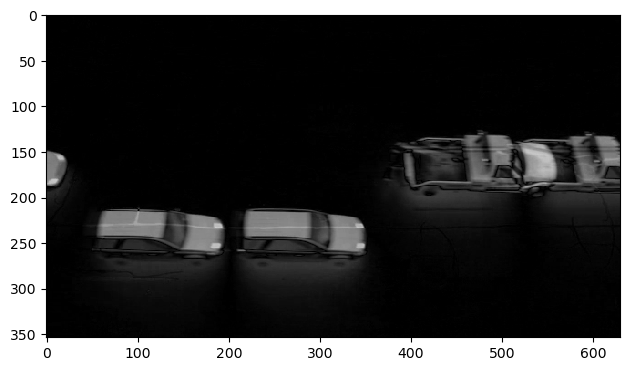

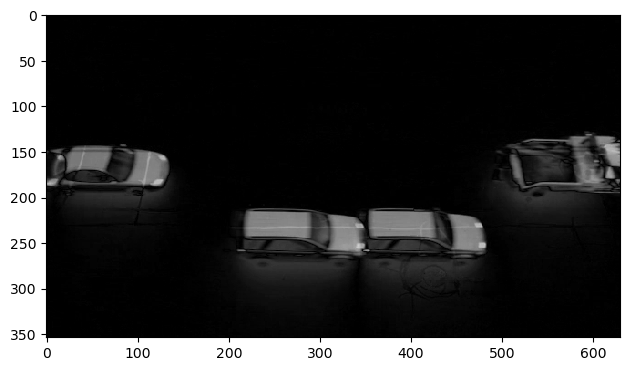

In [43]:
mostrar_frames(video_dif)

### Análisis de Resultados y Mejoras

Al analizar los resultados del análisis de diferencias, se observa que las áreas de movimiento (vehículos) aparecen borrosas y con "fantasmas" debido a que la diferencia simple entre frames captura el desplazamiento de los píxeles, mostrando tanto la posición anterior como la actual de los objetos en movimiento. Para mejorar estos resultados, se pueden aplicar técnicas de umbralización, operaciones morfológicas y etiquetado de componentes conectados.



## Extracción de Fondo

El siguiente paso consiste en determinar un frame de fondo que represente la escena estática. El fondo es todo aquello que permanece regular a lo largo del tiempo, mientras que los objetos en movimiento (vehículos) son lo que cambia. Se puede utilizar un estadístico aplicado sobre todos los frames (como la mediana o la media) o un frame específico que represente la escena sin vehículos.



In [ ]:
def extrae_fondo(video):
    '''
    Determina el fondo a partir de los frames de entrada utilizando la mediana de todos los frames.
    La mediana es robusta a valores atípicos (vehículos en movimiento) y captura mejor el fondo estático.
    
    Parámetros:
    - video: lista de frames en escala de grises
    
    Devuelve:
    - fondo: frame que representa el fondo de la escena
    '''
    # Convertir la lista de frames a un array numpy
    video_array = np.array(video)
    
    # Calcular la mediana a lo largo del eje temporal (eje 0)
    # Esto captura el valor más común en cada píxel, que corresponde al fondo
    fondo = np.median(video_array, axis=0)
    
    return fondo

In [46]:
fondo = extrae_fondo(video_gris)
io.imshow(fondo)
io.show()

NameError: name 'fondo' is not defined

## Análisis de diferencias con el fondo

Una vez obtenido el fondo deseado repetimos el análisis de diferencias, en vez de hacerlo con frames consecutimos del frame actual vs el fondo que hemos calculado en el paso anterior.$$IMG_{dif} = Abs(IMG_{n}- IMG_{fondo})$$



In [49]:
def calcula_diferencias_fondo(video, fondo):
    '''
    Realiza el análisis de diferencias con el fondo
    Devuelve una secuencia de frames de salida
    '''
    out = []
    
    # Convertir el fondo a escala de grises si es necesario
    if len(fondo.shape) == 3:
        fondo_gray = rgb2gray(fondo)
    else:
        fondo_gray = fondo
    
    # Asegurarse de que el fondo esté en el rango [0, 1]
    if fondo_gray.max() > 1.0:
        fondo_gray = fondo_gray / 255.0
    
    # Procesar cada frame del video
    for frame in video:
        # Convertir el frame a escala de grises si es necesario
        if len(frame.shape) == 3:
            frame_gray = rgb2gray(frame)
        else:
            frame_gray = frame
        
        # Asegurarse de que el frame esté en el mismo rango que el fondo
        if frame_gray.max() > 1.0:
            frame_gray = frame_gray / 255.0
        
        # Calcular la diferencia absoluta con el fondo
        diff = np.abs(frame_gray - fondo_gray)
        
        # Escalar de vuelta a 0-255 y convertir a uint8
        diff_uint8 = (diff * 255).astype(np.uint8)
        
        out.append(diff_uint8)
    
    return out

In [54]:
# Tomar el primer frame del video como fondo
fondo = video_gris[0]
video_dif_fondo = calcula_diferencias_fondo(video_gris, fondo)

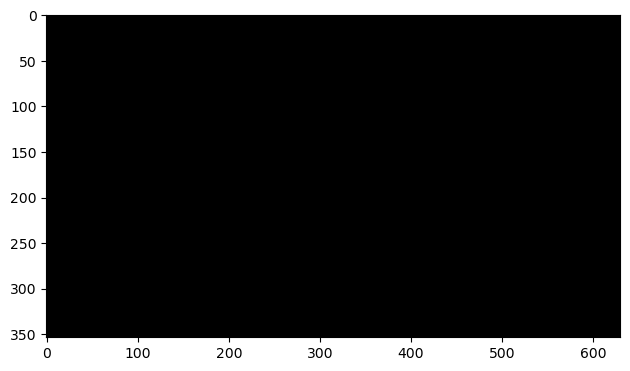

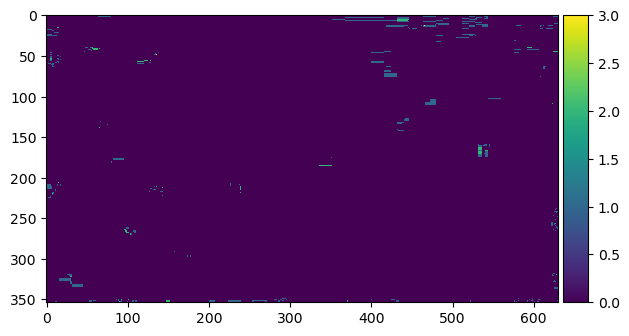

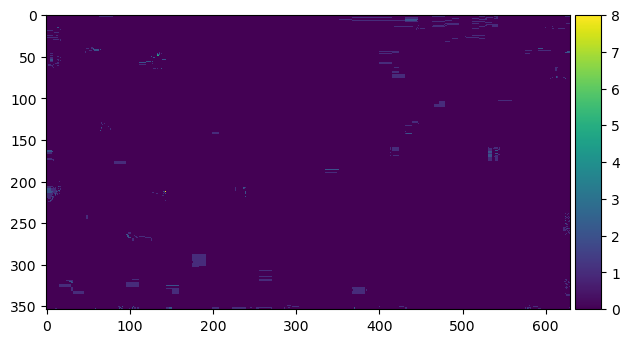

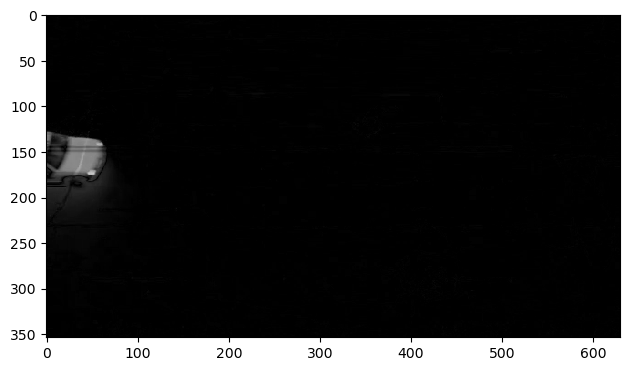

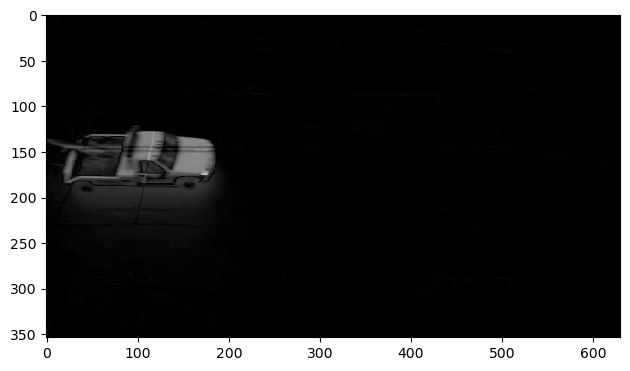

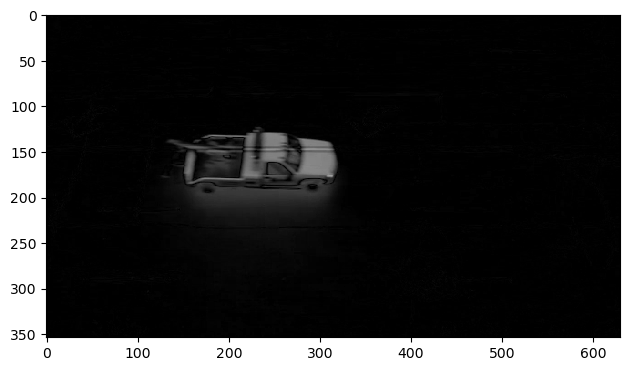

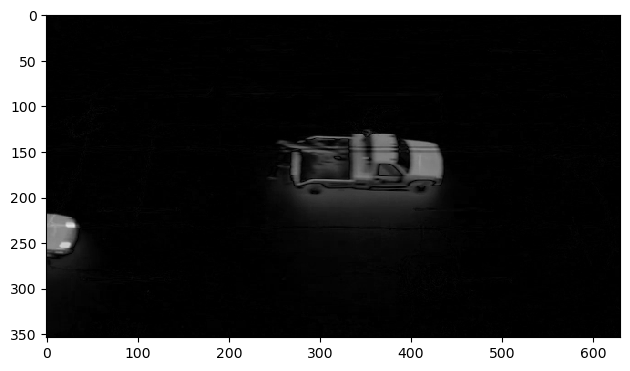

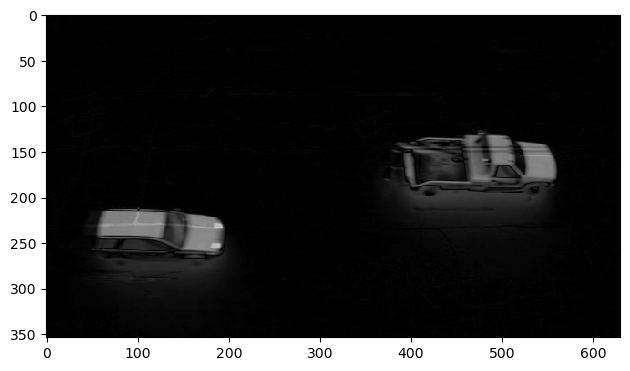

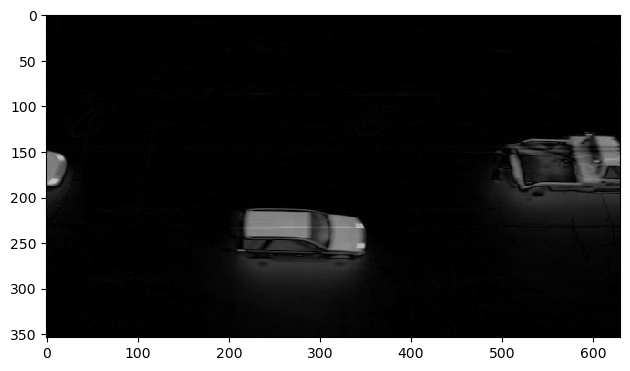

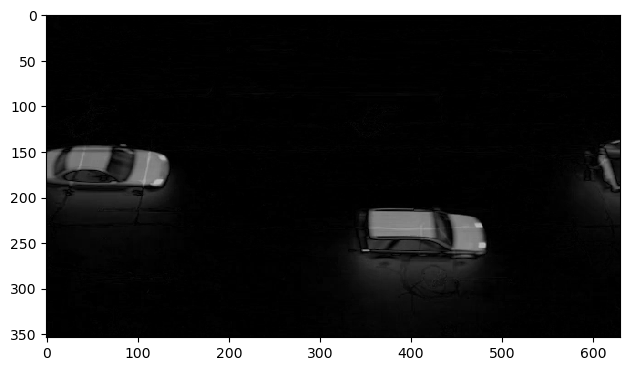

In [55]:
mostrar_frames(video_dif_fondo)

## Binarización

El siguiente paso que os propongo es binarizar la imagen de diferencias con el objetivo de enmascar los resultados en la etapa siguiente.



In [65]:
def binariza_video(video):
    '''
    Convierte cada frame del video a una imagen binaria usando umbralización de Otsu.
    
    Parámetros:
    - video: lista de frames (cada frame debe estar en el rango [0,1] o [0,255])
    
    Devuelve:
    - Lista de frames binarios (valores 0 o 255)
    '''
    out = []
    
    for frame in video:
        # Asegurarse de que el frame esté en el rango [0,1]
        if frame.max() > 1.0:
            frame_norm = frame / 255.0
        else:
            frame_norm = frame.copy()
        
        # Calcular umbral automáticamente usando el método de Otsu
        umbral = threshold_otsu(frame_norm)
        
        # Binarizar la imagen
        binario = (frame_norm > umbral).astype(np.uint8) * 255
        
        out.append(binario)
    
    return out

In [66]:
video_dif_fondo_umbralizada = binariza_video(video_dif_fondo)

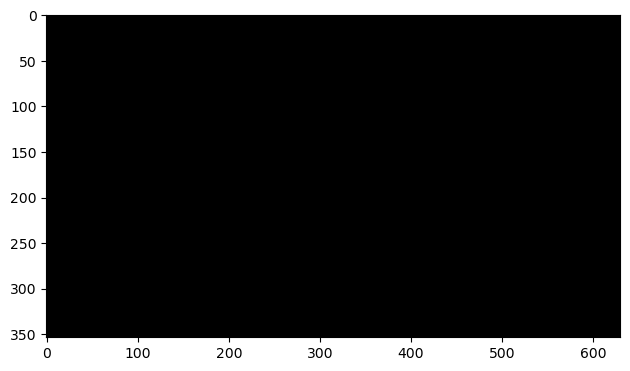

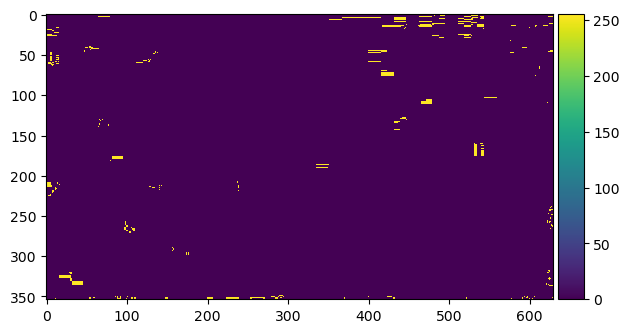

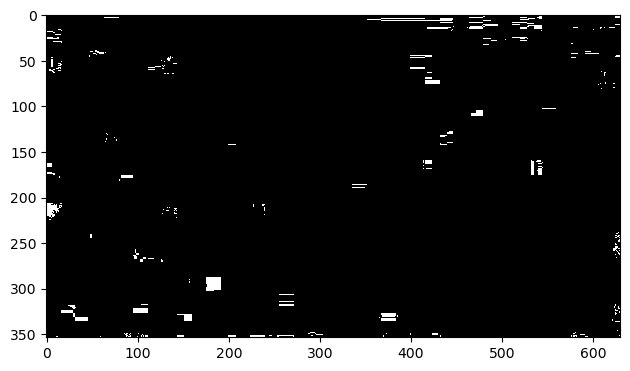

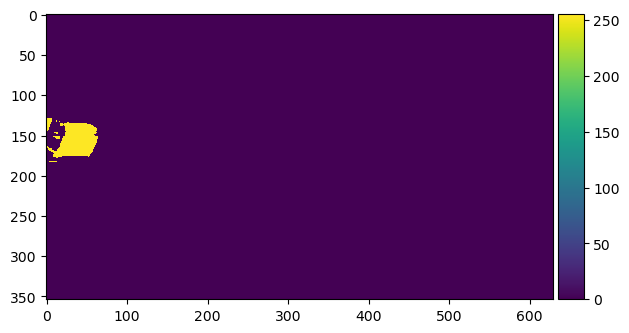

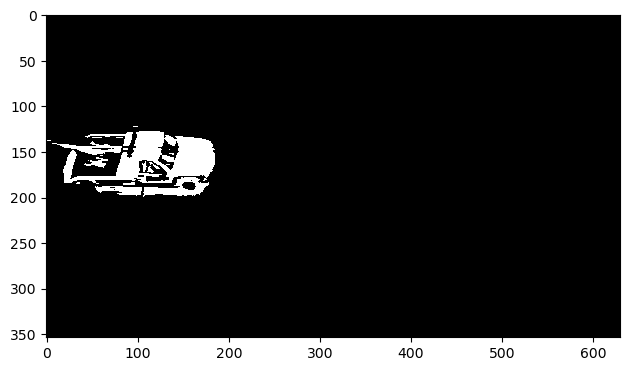

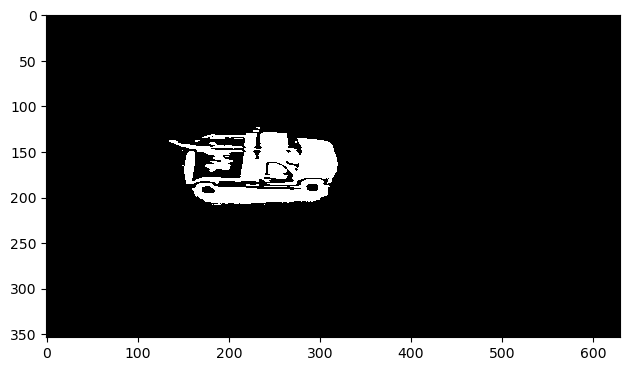

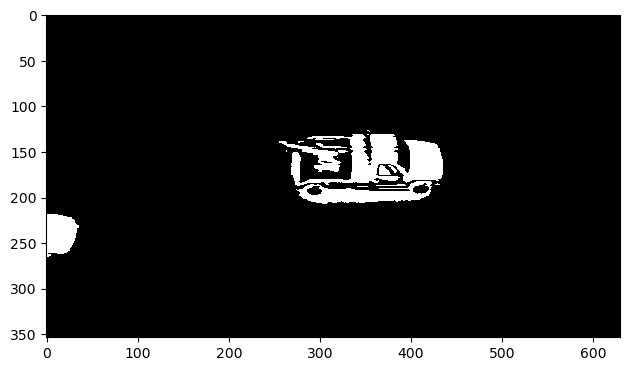

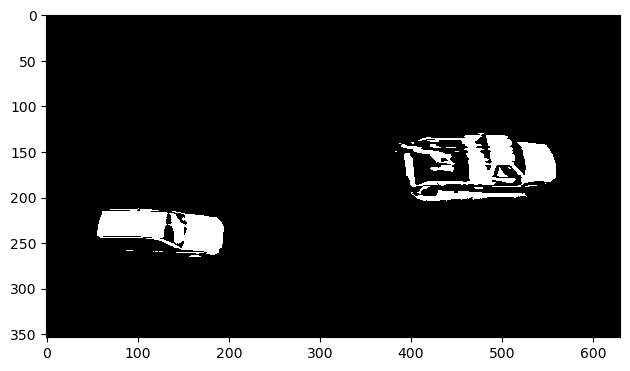

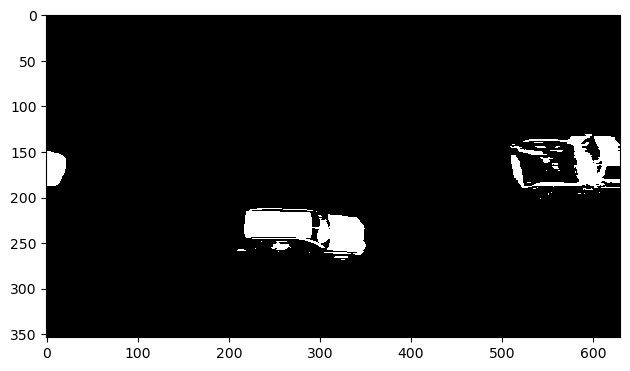

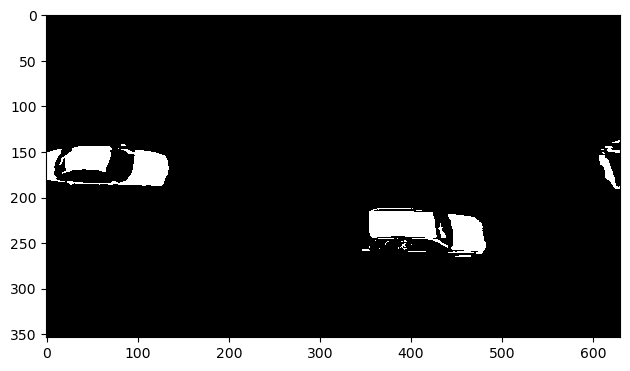

In [67]:
mostrar_frames(video_dif_fondo_umbralizada)

## Filtros morfológicos

Como podemos ver en la imagen de diferencias obtenida, aunque tiene bastante buena pinta si queremos identificar los coches deberíamos filtrarla para que cada blob sea un elemento perfectamente conectado, esto ayudará mucho al algoritmo de extracción de blobs.



In [109]:
def filtrar_morfo(video):
    '''
    Aplica operaciones morfológicas a cada frame del video para limpiar y mejorar los blobs.
    
    Parámetros:
    - video: lista de frames binarios (valores 0 o 255)
    
    Devuelve:
    - Lista de frames procesados
    '''
    out = []
    
    for frame in video:
        # Asegurarse de que el frame sea binario (0 o 255)
        if frame.max() == 1:
            frame = frame * 255
        
        # Convertir a tipo uint8 si es necesario
        frame = frame.astype(np.uint8)
                
        # 1. Apertura para eliminar ruido (pequeños puntos blancos)
        processed = opening(frame, disk(3))
        
        # 2. Cierre para rellenar huecos pequeños
        processed = closing(processed, disk(5))
        
        # 3. Erosión para separar objetos cercanos
        processed = erosion(processed, disk(9))
        
        # 4. Dilatación para agrandar regiones
        processed = dilation(processed, disk(15))
        
        # 5. Cierre final para suavizar bordes
        processed = closing(processed, disk(20))
        
        out.append(processed)
    
    return out

In [110]:
video_dif_fondo_umbralizada_filtered = filtrar_morfo(video_dif_fondo_umbralizada)

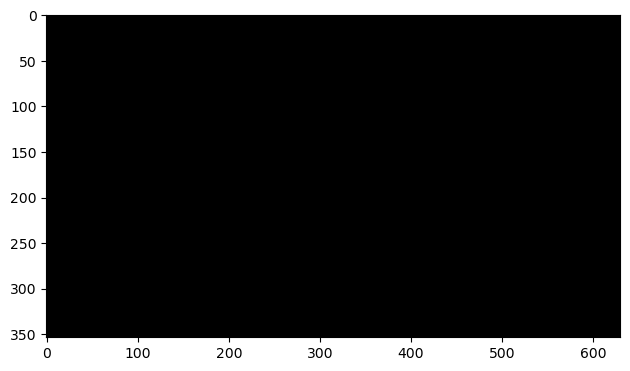

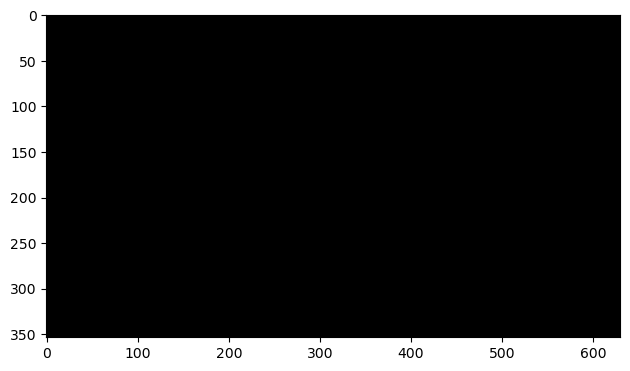

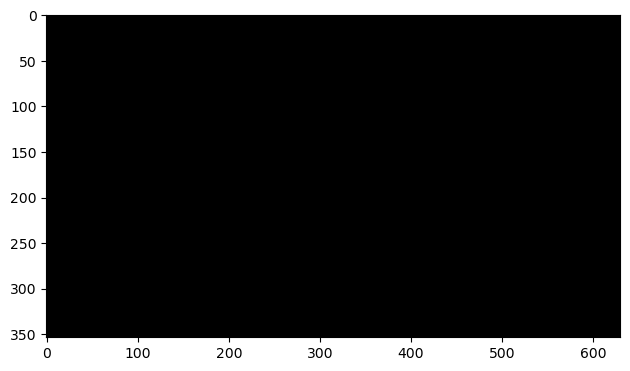

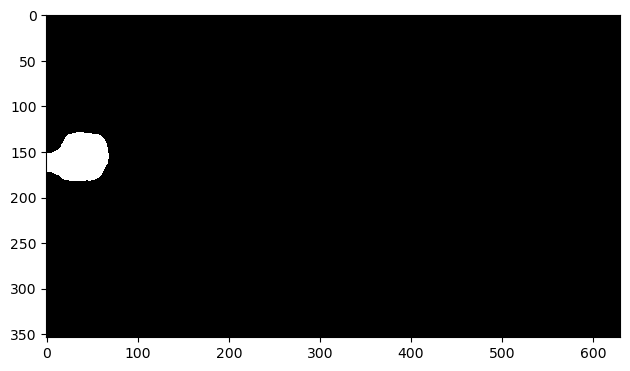

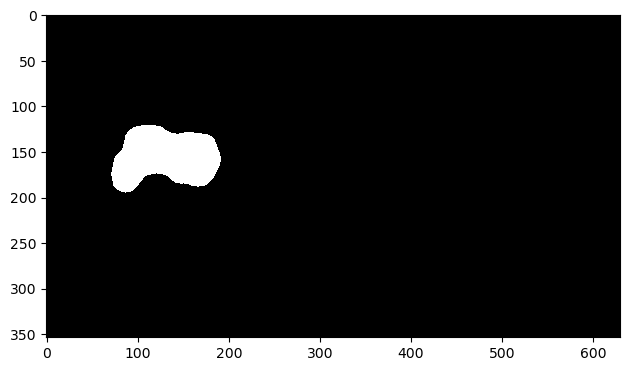

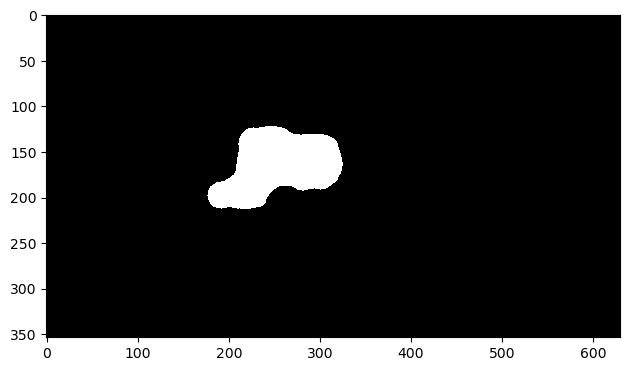

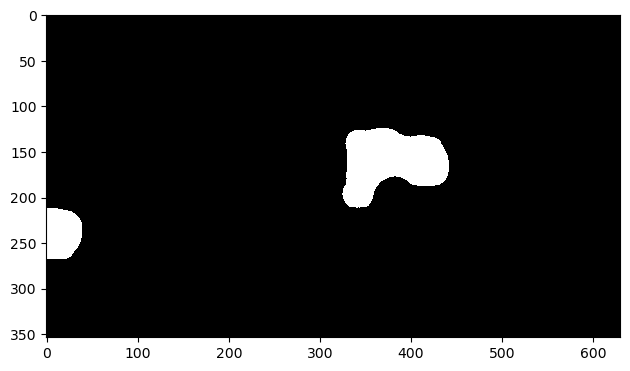

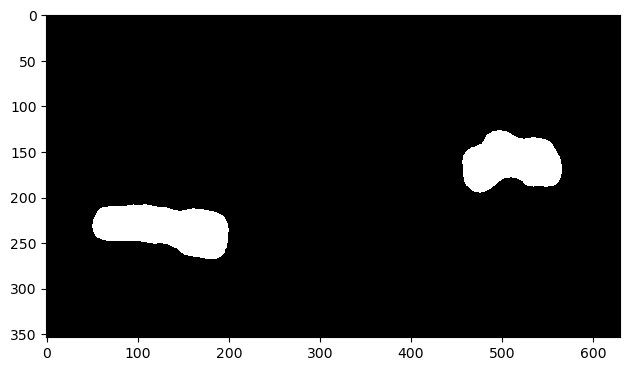

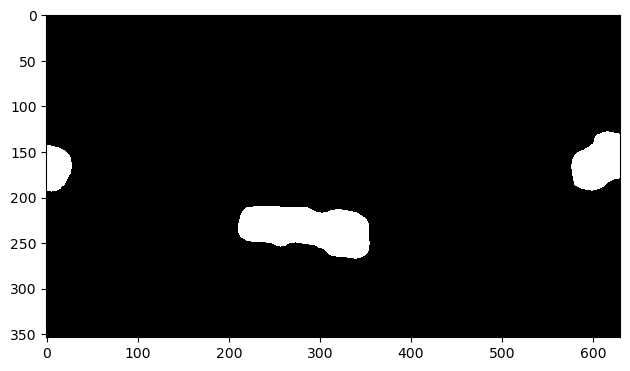

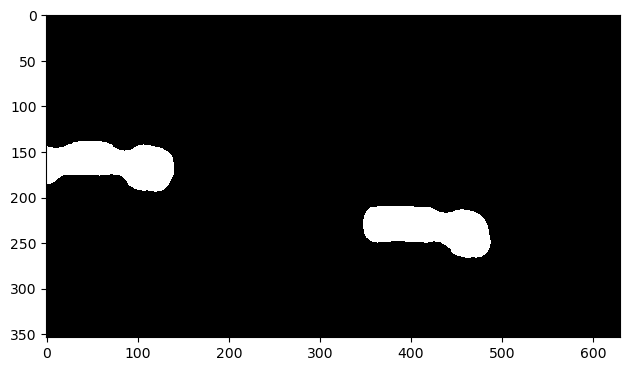

In [111]:
mostrar_frames(video_dif_fondo_umbralizada_filtered)

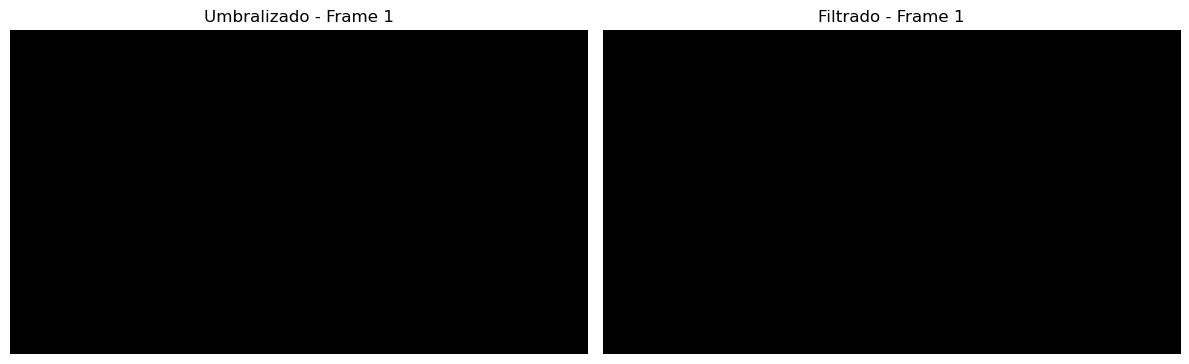

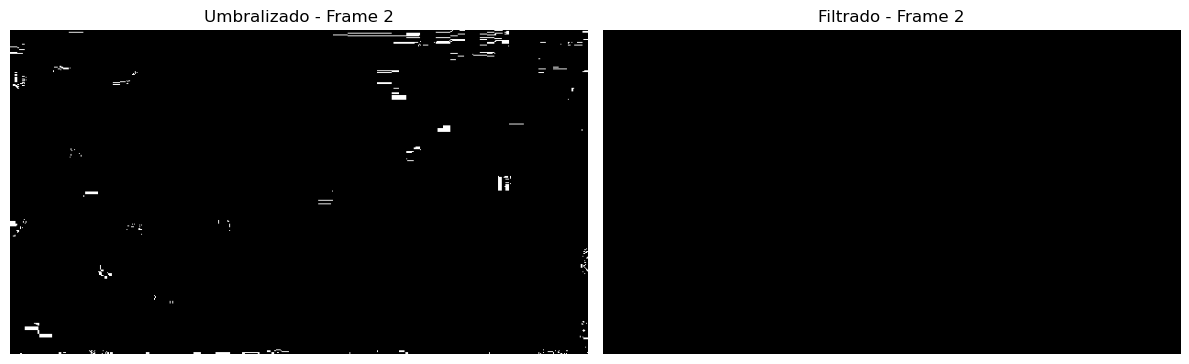

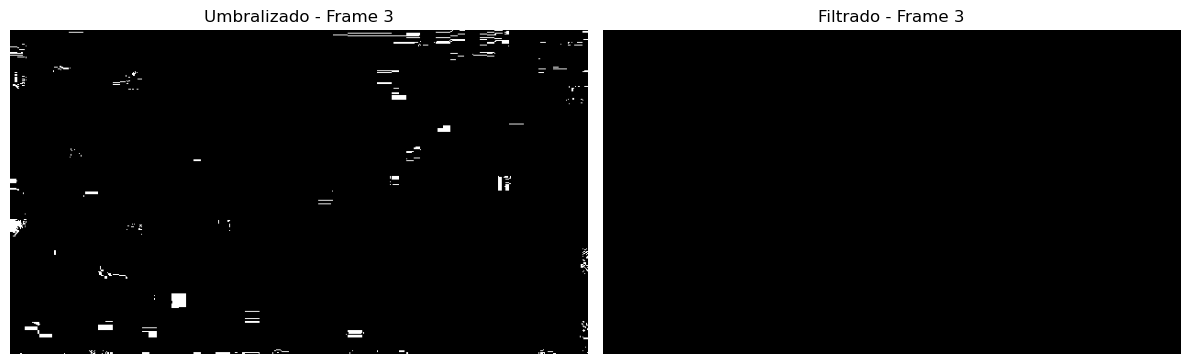

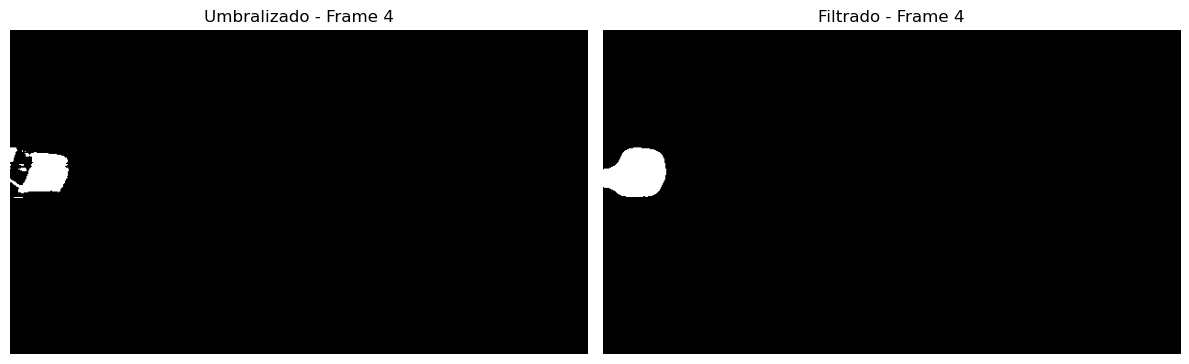

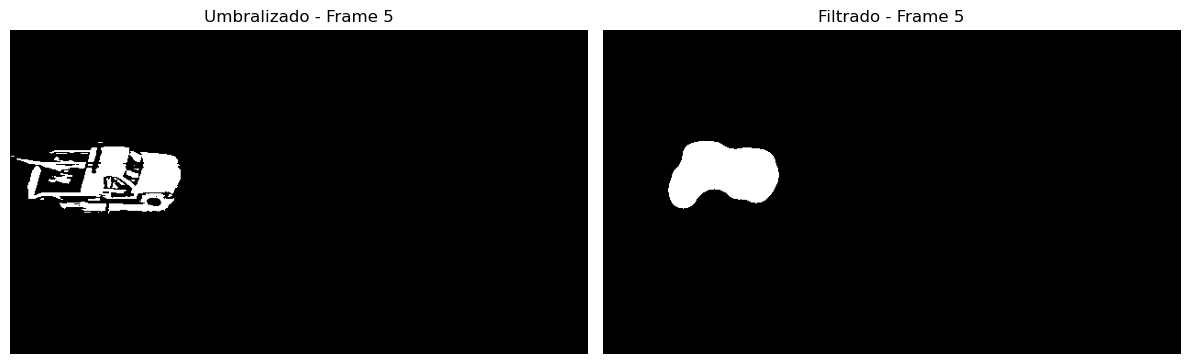

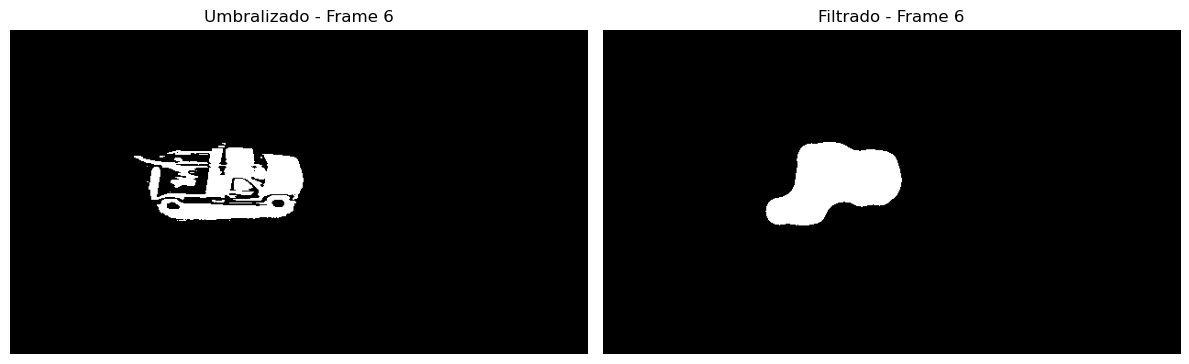

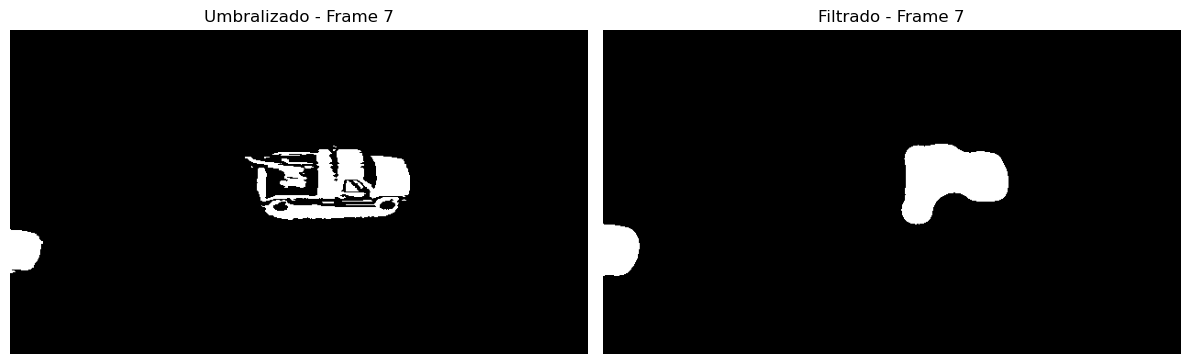

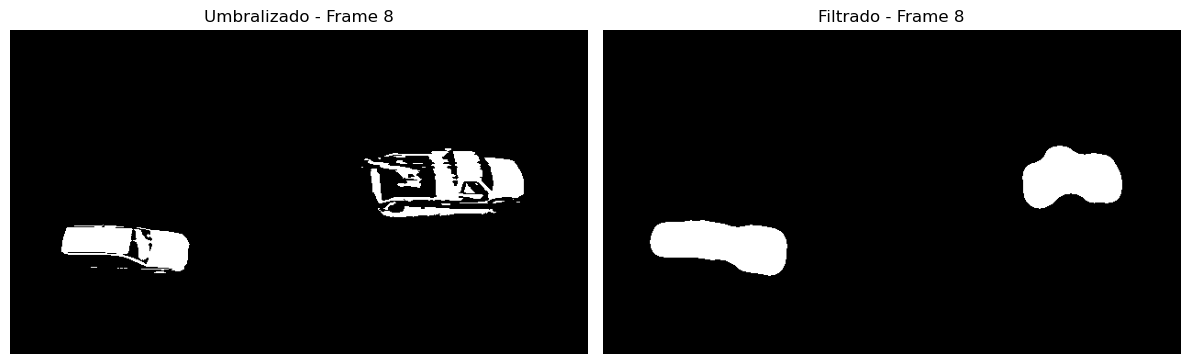

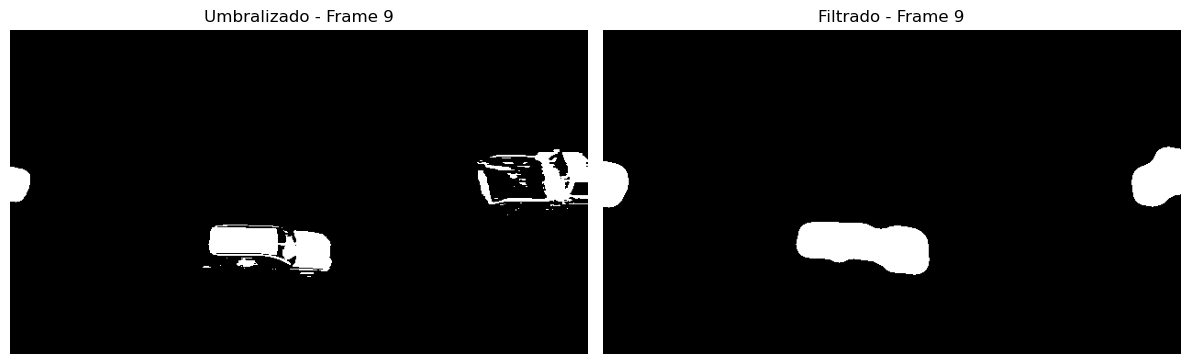

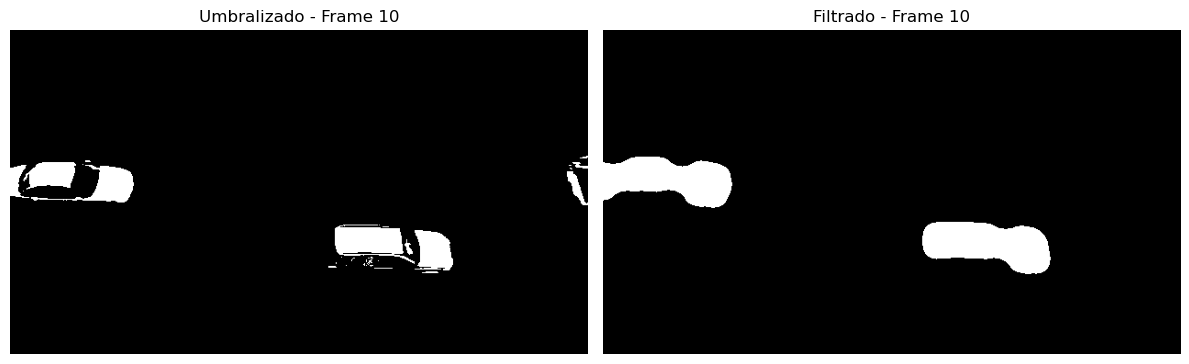

In [113]:
def mostrar_frames_doble(video1, video2, titulo1="Video 1", titulo2="Video 2"):
    '''
    Muestra todos los frames de dos videos en paralelo.
    
    Parámetros:
    - video1: primer video (lista de frames)
    - video2: segundo video (lista de frames)
    - titulo1: título para el primer video (opcional)
    - titulo2: título para el segundo video (opcional)
    '''
    # Determinar el número de frames a mostrar (el mínimo entre ambos videos)
    num_frames = min(len(video1), len(video2))
    
    for i in range(num_frames):
        # Configurar la figura para mostrar lado a lado
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Mostrar frame del primer video
        ax1.imshow(video1[i], cmap='gray')
        ax1.set_title(f'{titulo1} - Frame {i+1}')
        ax1.axis('off')
        
        # Mostrar frame del segundo video
        ax2.imshow(video2[i], cmap='gray')
        ax2.set_title(f'{titulo2} - Frame {i+1}')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()


mostrar_frames_doble(
     video_dif_fondo_umbralizada, 
     video_dif_fondo_umbralizada_filtered,
     titulo1="Umbralizado",
     titulo2="Filtrado"
)

## Análisis de blobs

Una vez obtenida la máscara binarizada te propongo que extraígamos los blobs de la imagen:



In [114]:
def extraer_blobs(video, min_area=100, max_area=10000):
    '''
    Extrae los blobs de cada frame del video.
    
    Parámetros:
    - video: lista de frames binarios (valores 0 o 255)
    - min_area: área mínima para considerar un blob (por defecto 100 píxeles)
    - max_area: área máxima para considerar un blob (por defecto 10000 píxeles)
    
    Devuelve:
    - Lista de listas, donde cada lista interna contiene los blobs de un frame
      Cada blob es un diccionario con propiedades como 'etiqueta', 'area', 'centroide', etc.
    '''
    all_blobs = []
    
    for frame in video:
        # Asegurarse de que el frame sea binario (0 o 1)
        if frame.max() > 1:
            frame_bin = (frame > 0).astype(int)
        else:
            frame_bin = frame
        
        # Etiquetar componentes conectados
        labeled_frame = measure.label(frame_bin)
        
        # Obtener propiedades de las regiones
        regions = measure.regionprops(labeled_frame)
        
        # Filtrar regiones por área y guardar propiedades relevantes
        frame_blobs = []
        for region in regions:
            if min_area <= region.area <= max_area:
                blob = {
                    'etiqueta': region.label,
                    'area': region.area,
                    'centroide': region.centroid,  # (fila, columna)
                    'bbox': region.bbox,  # (min_row, min_col, max_row, max_col)
                    'excentricidad': region.eccentricity,
                    'perimetro': region.perimeter
                }
                frame_blobs.append(blob)
        
        all_blobs.append(frame_blobs)
    
    return all_blobs

In [115]:
all_blobs = extraer_blobs(video_dif_fondo_umbralizada_filtered)

Mostramos los resultados:



In [116]:
def mostrar_blobs(img, blobs):
    '''
    Muestra una imagen con los blobs dibujados.
    
    Parámetros:
    - img: imagen de entrada
    - blobs: lista de diccionarios con las propiedades de los blobs
    '''
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img, cmap=plt.cm.gray)
    
    for blob in blobs:
        # Obtener coordenadas de la bounding box
        min_row, min_col, max_row, max_col = blob['bbox']
        width = max_col - min_col
        height = max_row - min_row
        
        # Crear un rectángulo para mostrar el blob
        rect = plt.Rectangle((min_col, min_row), width, height, 
                            fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
        # Mostrar el centroide
        y, x = blob['centroide']
        plt.plot(x, y, 'r+')
    
    plt.axis('off')
    plt.show()
    
    # Mostrar información de los blobs
    print(f"Se encontraron {len(blobs)} blobs")
    for i, blob in enumerate(blobs, 1):
        print(f"Blob {i}:")
        print(f"  - Área: {blob['area']:.2f} píxeles")
        print(f"  - Centroide: ({blob['centroide'][0]:.1f}, {blob['centroide'][1]:.1f})")
        print(f"  - Bounding box: {blob['bbox']}")

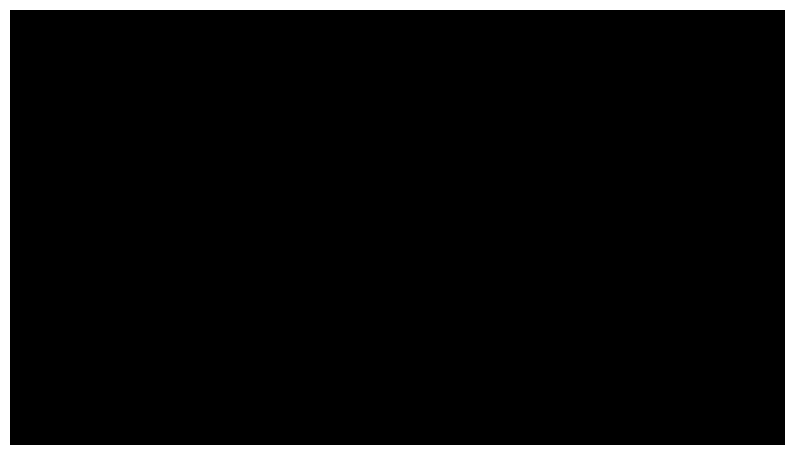

Se encontraron 0 blobs
[0] Blobs: 0


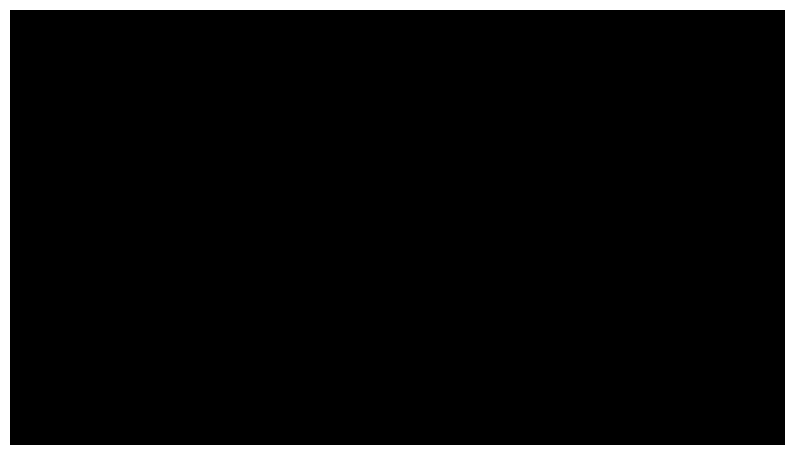

Se encontraron 0 blobs
[1] Blobs: 0


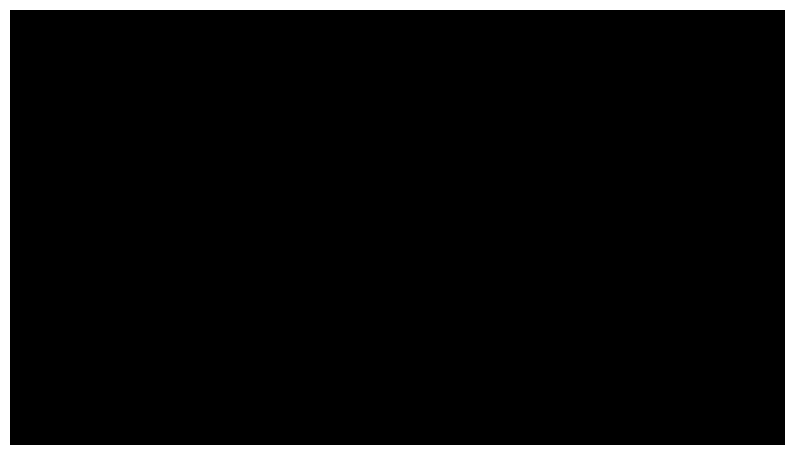

Se encontraron 0 blobs
[2] Blobs: 0


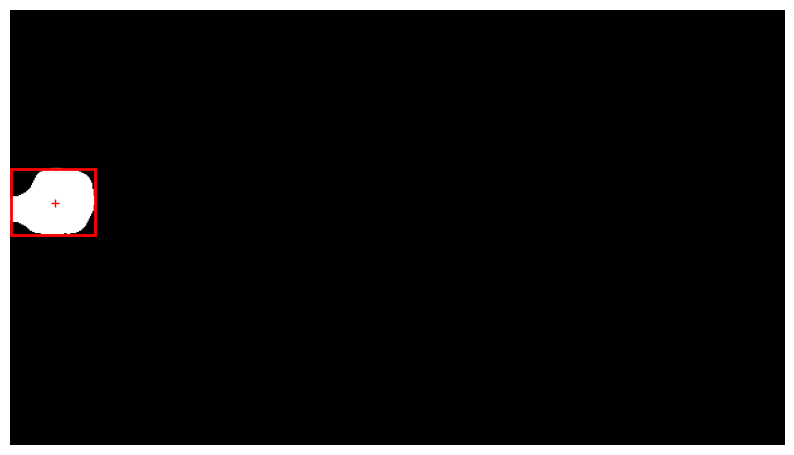

Se encontraron 1 blobs
Blob 1:
  - Área: 2872.00 píxeles
  - Centroide: (156.9, 36.3)
  - Bounding box: (129, 0, 183, 69)
[3] Blobs: 1


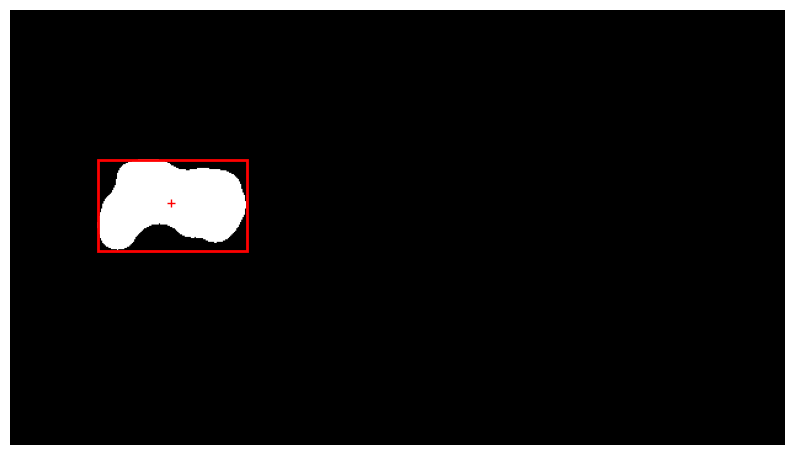

Se encontraron 1 blobs
Blob 1:
  - Área: 6308.00 píxeles
  - Centroide: (157.0, 130.4)
  - Bounding box: (122, 71, 196, 192)
[4] Blobs: 1


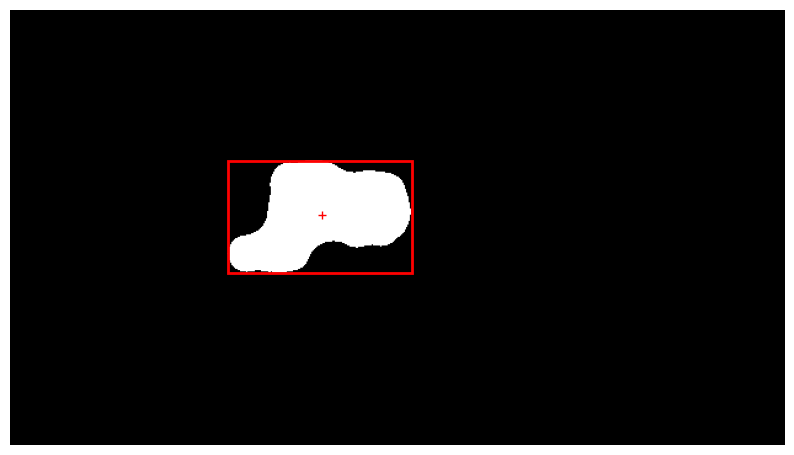

Se encontraron 1 blobs
Blob 1:
  - Área: 8587.00 píxeles
  - Centroide: (166.9, 253.3)
  - Bounding box: (123, 177, 214, 326)
[5] Blobs: 1


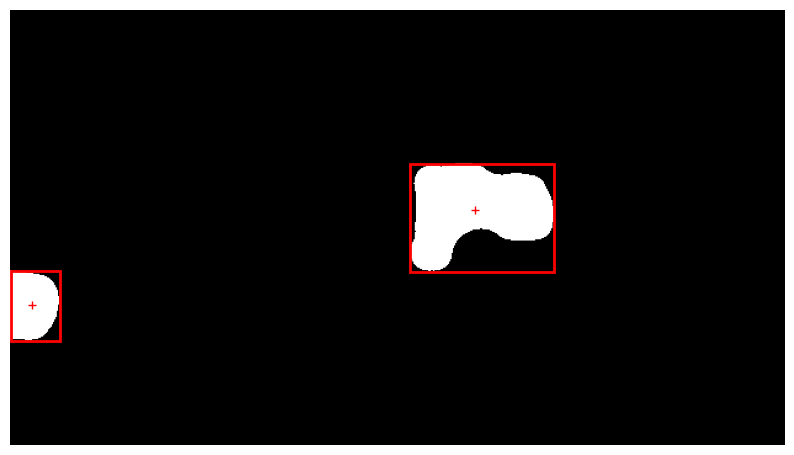

Se encontraron 2 blobs
Blob 1:
  - Área: 6773.00 píxeles
  - Centroide: (162.1, 377.5)
  - Bounding box: (125, 325, 213, 442)
Blob 2:
  - Área: 1912.00 píxeles
  - Centroide: (240.1, 17.2)
  - Bounding box: (212, 0, 269, 40)
[6] Blobs: 2


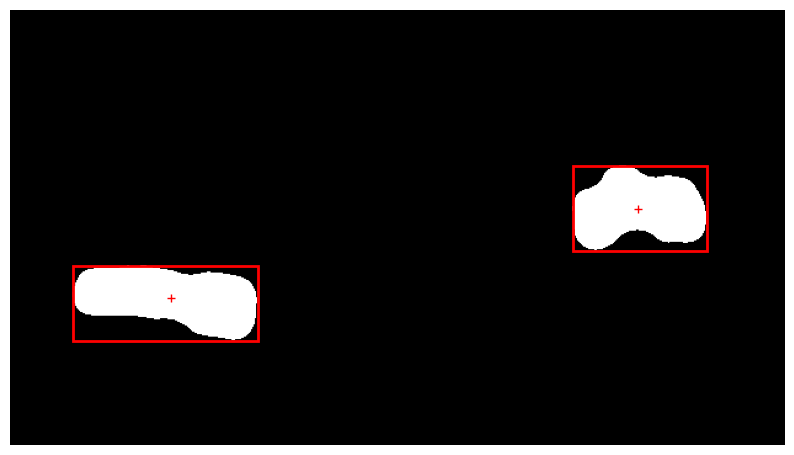

Se encontraron 2 blobs
Blob 1:
  - Área: 5353.00 píxeles
  - Centroide: (161.7, 510.2)
  - Bounding box: (127, 457, 196, 566)
Blob 2:
  - Área: 6284.00 píxeles
  - Centroide: (234.4, 130.3)
  - Bounding box: (208, 51, 269, 201)
[7] Blobs: 2


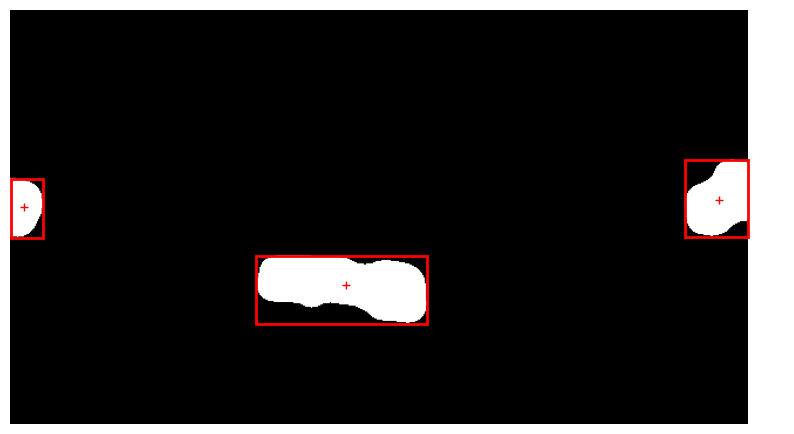

Se encontraron 3 blobs
Blob 1:
  - Área: 2631.00 píxeles
  - Centroide: (162.3, 605.1)
  - Bounding box: (128, 576, 194, 630)
Blob 2:
  - Área: 1150.00 píxeles
  - Centroide: (168.4, 11.6)
  - Bounding box: (144, 0, 195, 28)
Blob 3:
  - Área: 6057.00 píxeles
  - Centroide: (235.0, 286.3)
  - Bounding box: (210, 210, 268, 356)
[8] Blobs: 3


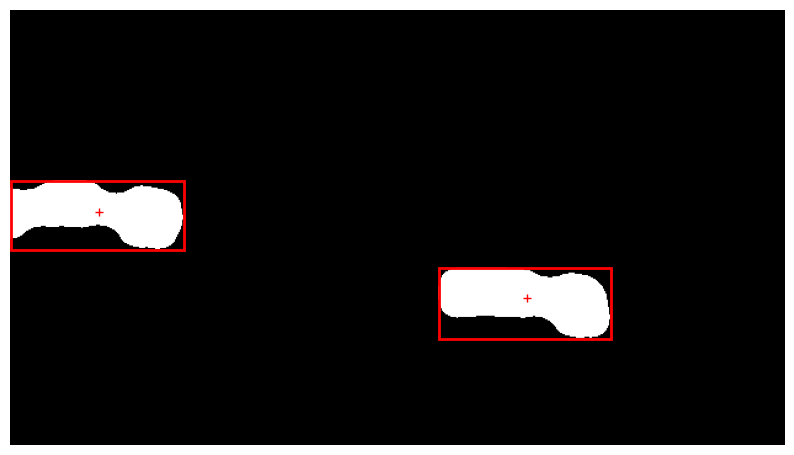

Se encontraron 2 blobs
Blob 1:
  - Área: 5390.00 píxeles
  - Centroide: (163.7, 72.2)
  - Bounding box: (139, 0, 195, 141)
Blob 2:
  - Área: 5586.00 píxeles
  - Centroide: (234.2, 420.0)
  - Bounding box: (210, 348, 267, 488)
[9] Blobs: 2


In [117]:
for i in range(len(video_dif_fondo_umbralizada_filtered)):
    img = video_dif_fondo_umbralizada_filtered[i]
    blobs = all_blobs[i]

    mostrar_blobs(img, blobs)
    print("[{}] Blobs: {}".format(i, len(blobs)))

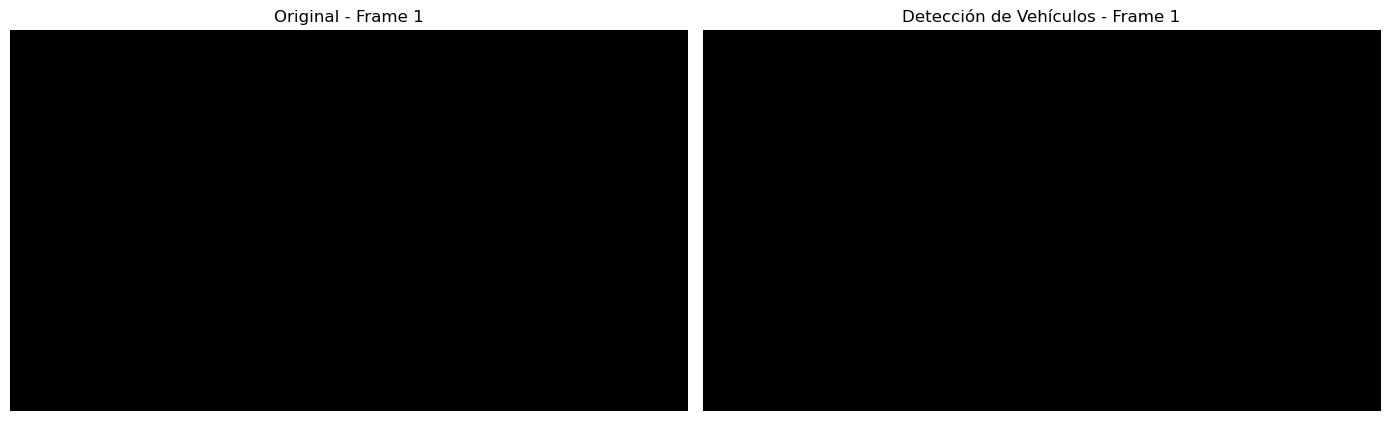

[Frame 1] Blobs detectados: 0
--------------------------------------------------


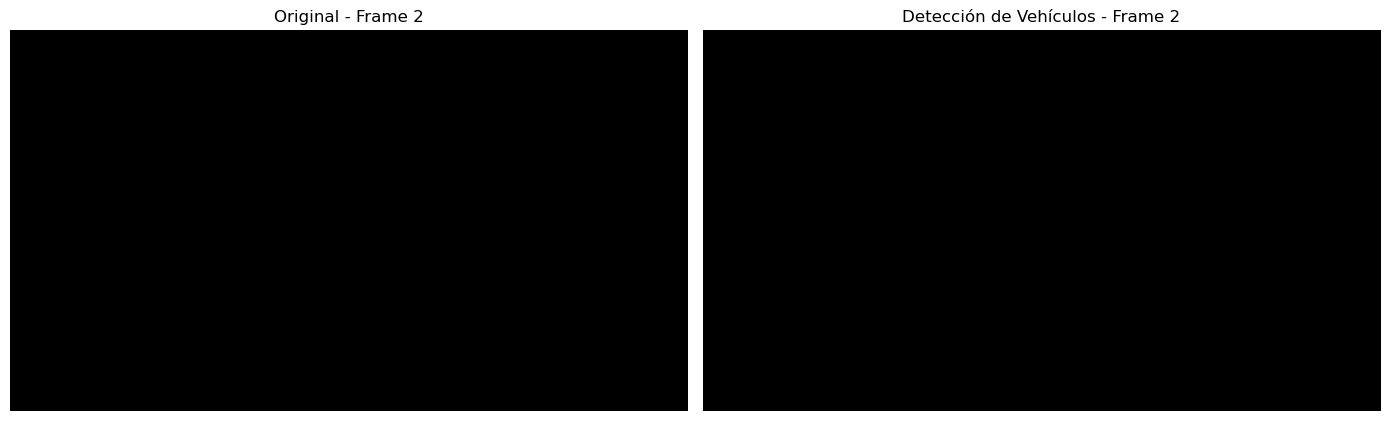

[Frame 2] Blobs detectados: 0
--------------------------------------------------


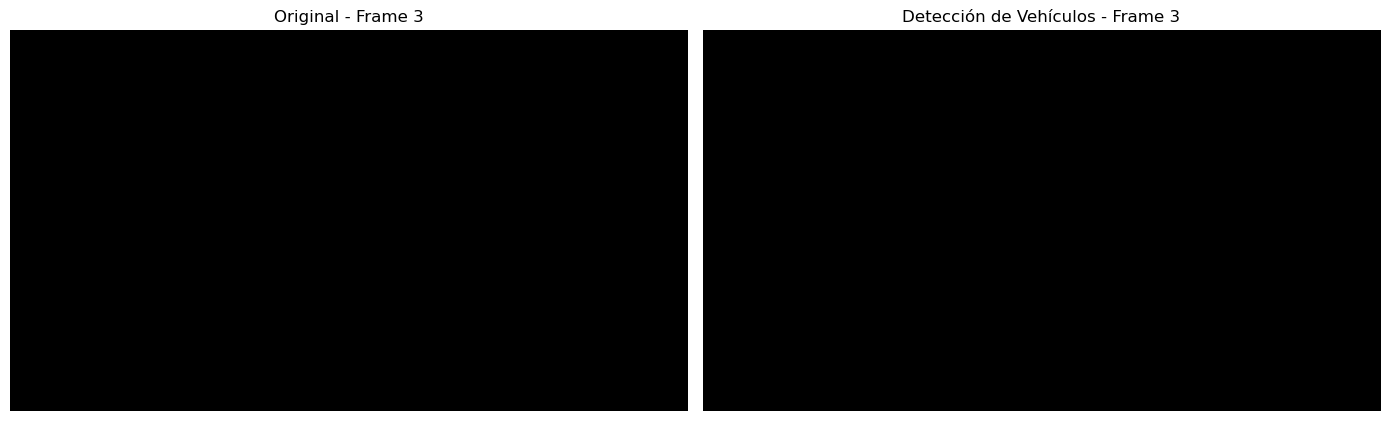

[Frame 3] Blobs detectados: 0
--------------------------------------------------


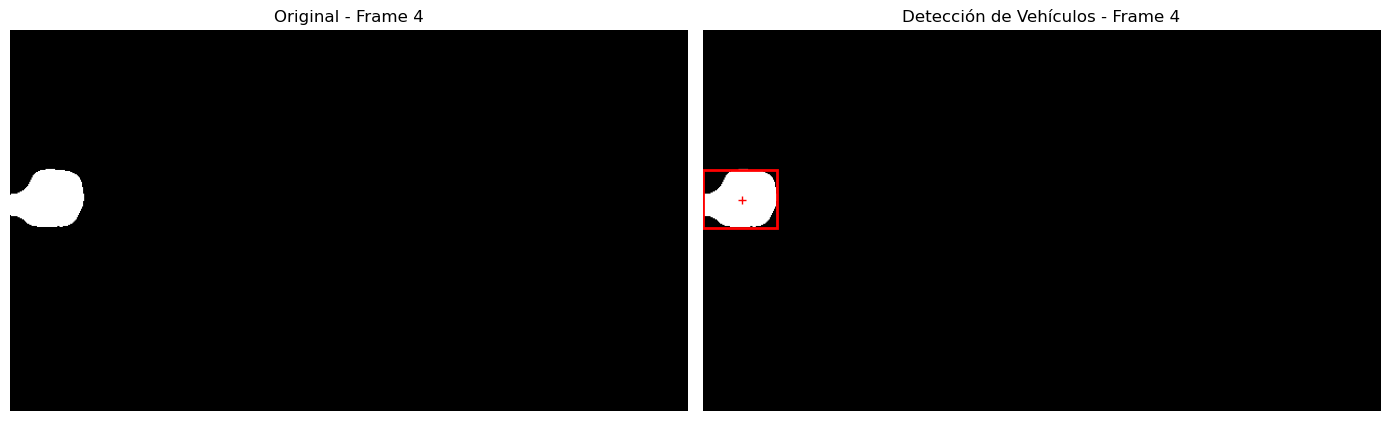

[Frame 4] Blobs detectados: 1
  Blob 1: Área=2872.0, Centroide=(36.3, 156.9)
--------------------------------------------------


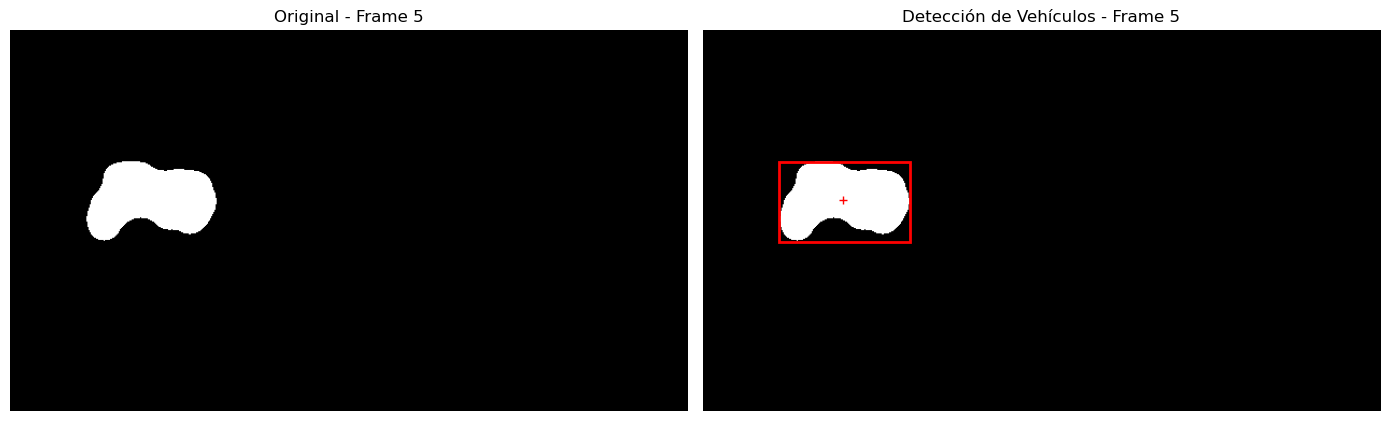

[Frame 5] Blobs detectados: 1
  Blob 1: Área=6308.0, Centroide=(130.4, 157.0)
--------------------------------------------------


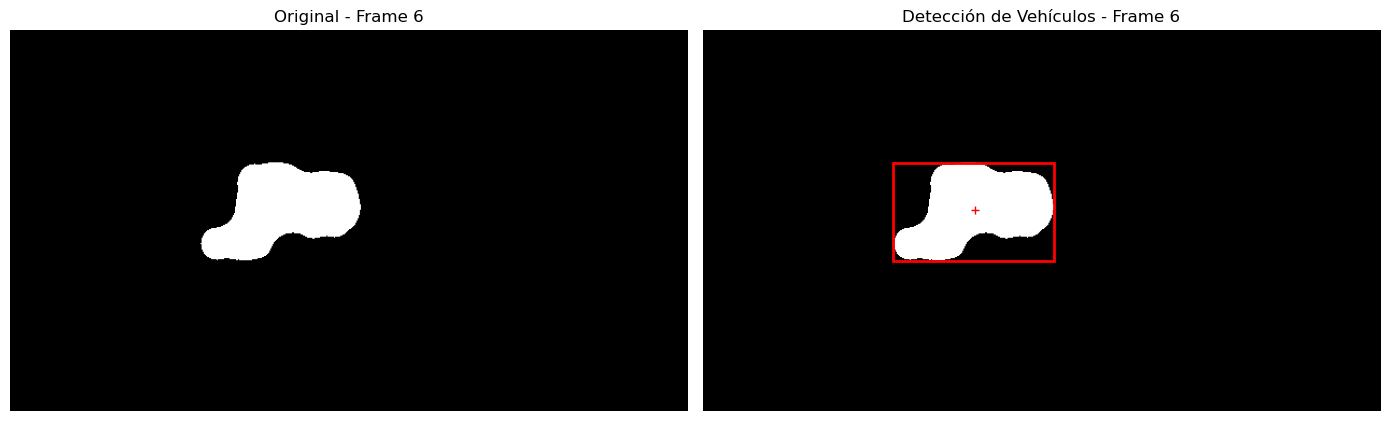

[Frame 6] Blobs detectados: 1
  Blob 1: Área=8587.0, Centroide=(253.3, 166.9)
--------------------------------------------------


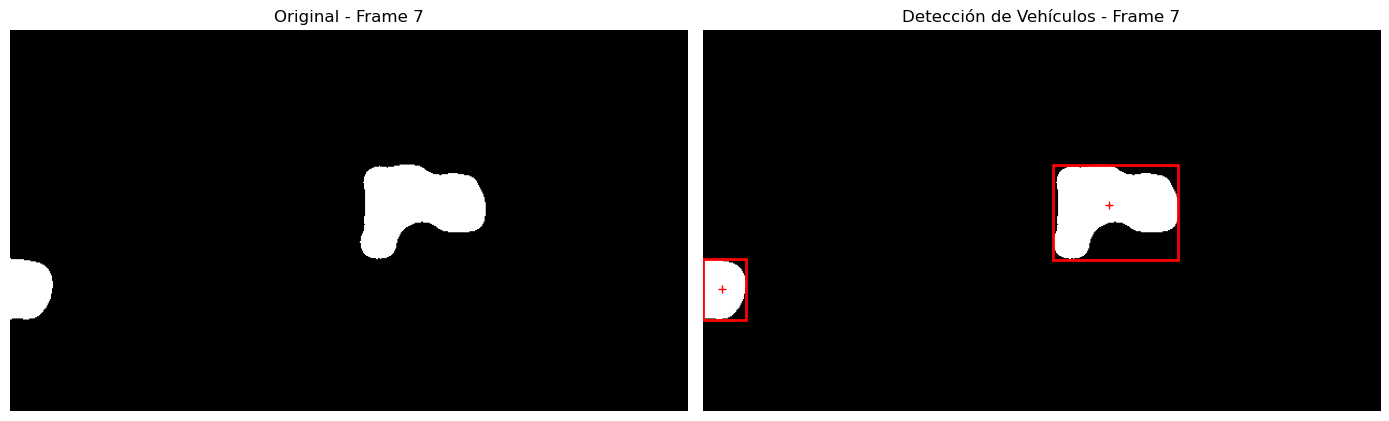

[Frame 7] Blobs detectados: 2
  Blob 1: Área=6773.0, Centroide=(377.5, 162.1)
  Blob 2: Área=1912.0, Centroide=(17.2, 240.1)
--------------------------------------------------


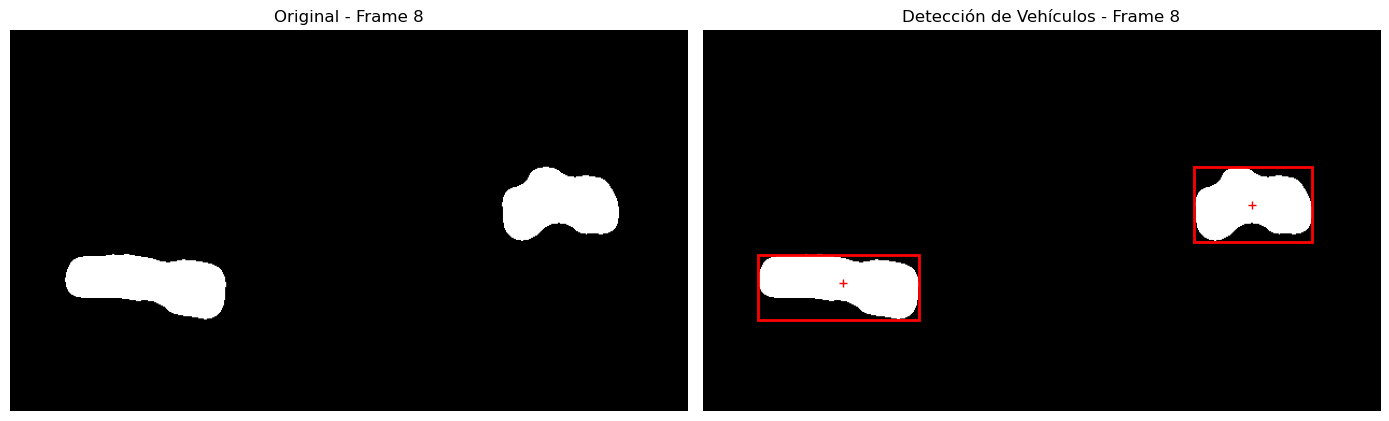

[Frame 8] Blobs detectados: 2
  Blob 1: Área=5353.0, Centroide=(510.2, 161.7)
  Blob 2: Área=6284.0, Centroide=(130.3, 234.4)
--------------------------------------------------


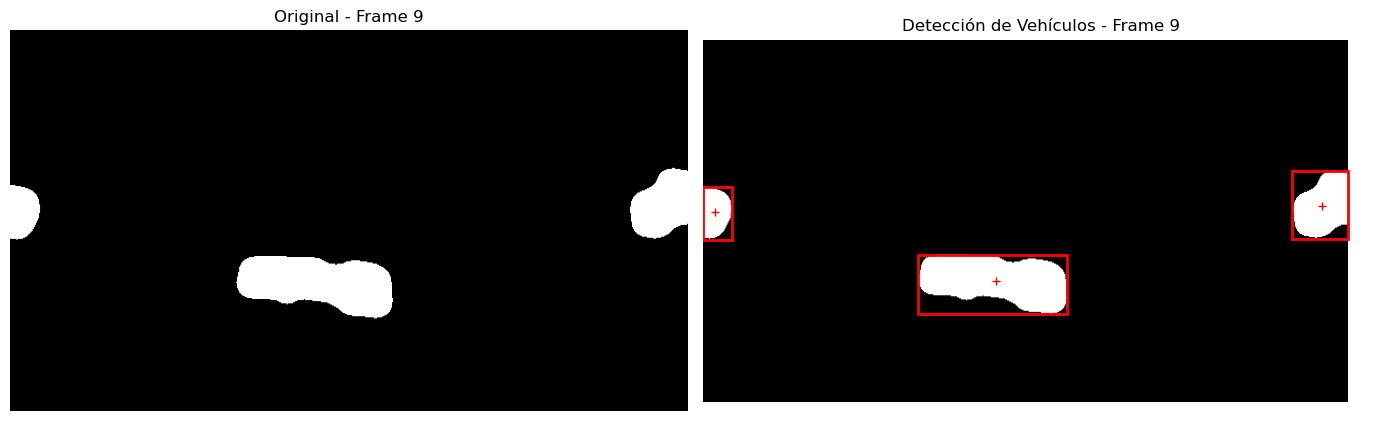

[Frame 9] Blobs detectados: 3
  Blob 1: Área=2631.0, Centroide=(605.1, 162.3)
  Blob 2: Área=1150.0, Centroide=(11.6, 168.4)
  Blob 3: Área=6057.0, Centroide=(286.3, 235.0)
--------------------------------------------------


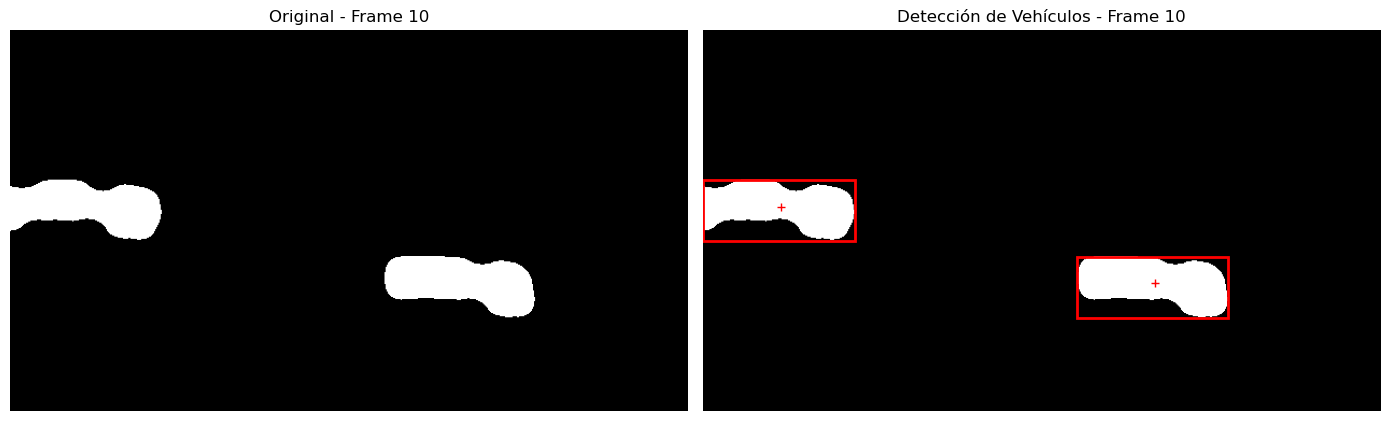

[Frame 10] Blobs detectados: 2
  Blob 1: Área=5390.0, Centroide=(72.2, 163.7)
  Blob 2: Área=5586.0, Centroide=(420.0, 234.2)
--------------------------------------------------


In [120]:
def mostrar_frames_con_blobs(video_original, lista_blobs, titulo_original="Original", titulo_blobs="Con Blobs"):
    '''
    Muestra en paralelo el frame original y el mismo frame con los blobs detectados.
    
    Parámetros:
    - video_original: lista de frames originales
    - lista_blobs: lista de listas de blobs (resultado de extraer_blobs)
    - titulo_original: título para el frame original (opcional)
    - titulo_blobs: título para el frame con blobs (opcional)
    '''
    for i in range(min(len(video_original), len(lista_blobs))):
        img = video_original[i]
        blobs = lista_blobs[i]
        
        # Crear figura con dos subplots lado a lado
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Mostrar frame original
        ax1.imshow(img, cmap='gray')
        ax1.set_title(f'{titulo_original} - Frame {i+1}')
        ax1.axis('off')
        
        # Mostrar frame con blobs
        ax2.imshow(img, cmap='gray')
        ax2.set_title(f'{titulo_blobs} - Frame {i+1}')
        
        # Dibujar cada blob en el segundo subplot
        for blob in blobs:
            # Obtener coordenadas de la bounding box
            min_row, min_col, max_row, max_col = blob['bbox']
            width = max_col - min_col
            height = max_row - min_row
            
            # Dibujar rectángulo
            rect = plt.Rectangle((min_col, min_row), width, height, 
                                fill=False, edgecolor='red', linewidth=2)
            ax2.add_patch(rect)
            
            # Marcar centroide
            y, x = blob['centroide']
            ax2.plot(x, y, 'r+')
        
        ax2.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Mostrar información de los blobs
        print(f"[Frame {i+1}] Blobs detectados: {len(blobs)}")
        for j, blob in enumerate(blobs, 1):
            print(f"  Blob {j}: Área={blob['area']:.1f}, Centroide=({blob['centroide'][1]:.1f}, {blob['centroide'][0]:.1f})")
        print("-" * 50)

mostrar_frames_con_blobs(video_dif_fondo_umbralizada_filtered, all_blobs, 
                         "Original", "Detección de Vehículos")

In [ ]:
"""

- Frame 1: 0 coches
- Frame 2: 0 coches
- Frame 3: 0 coches
- Frame 4: 1 coche (área: 2872 píxeles)
- Frame 5: 1 coche (área: 6308 píxeles)
- Frame 6: 1 coche (área: 8587 píxeles)
- Frame 7: 2 coches (áreas: 6773 y 1912 píxeles)
- Frame 8: 2 coches (áreas: 5353 y 6284 píxeles)
- Frame 9: 3 coches (áreas: 2631, 1150 y 6057 píxeles)
- Frame 10: 2 coches (áreas: 5390 y 5586 píxeles)

Análisis:

- Los primeros 3 frames no muestran coches.
- Los frames 4-6 muestran un solo coche cada uno.
- A partir del frame 7, empiezan a aparecer más coches, con un máximo de 3 coches en el frame 9.
- El frame 10 muestra una disminución a 2 coches.


"""

In [ ]:
"""

Ventajas:

- Sencillo de implementar con bibliotecas estándar
- Rápido para videos cortos
- Efectivo en condiciones controladas (cámara fija, iluminación estable)

Inconvenientes:

- Problemas con oclusiones (coches que se tapan)
- Dificultad en condiciones climáticas adversas

"""

## Filtrado de blobs

Se aplica alguna manera de mejorar los blobs que hemos obtenido en la etapa anterior para mejorar los resultados.. Se analiza Podríamos filtrar blobs que a priori sepamos que están mal.



In [125]:
def es_blob_valido(blob):
    '''
    Determina si un blob es válido según ciertos criterios.
    
    Parámetros:
    - blob: diccionario con las propiedades del blob (de regionprops)
    
    Devuelve:
    - True si el blob es válido, False en caso contrario
    '''
    # Obtener propiedades del blob
    area = blob['area']
    centroide_y, centroide_x = blob['centroide']
    min_row, min_col, max_row, max_col = blob['bbox']
    
    # 1. Filtro de área
    if area < 100 or area > 10000:  # Ajusta estos valores según necesites
        return False
    
    # 2. Filtro de posición X (evitar bordes)
    margen = 50
    if centroide_x < margen or centroide_x > (640 - margen):  # Ajusta el ancho según tu video
        return False
    
    # 3. Filtro de relación de aspecto (ancho/alto)
    ancho = max_col - min_col
    alto = max_row - min_row
    relacion_aspecto = max(ancho, alto) / (min(ancho, alto) + 1e-5)  # Evitar división por cero
    
    # Los coches suelen tener una relación de aspecto razonable (no muy alargados)
    if relacion_aspecto > 5:  # Ajusta este valor según necesites
        return False
    
    # 4. Filtro de excentricidad (si está disponible)
    if 'excentricidad' in blob and blob['excentricidad'] > 0.9:
        return False
    
    # Si pasa todos los filtros, es un blob válido
    return True

Ahora aplicamos el filtro que hemos implementado:



In [126]:
def filtrar_blobs(all_blobs):
    """Recorre todos los blobs de cada frame y almacena sólo los blobs que satisfacen es_blob_valido"""
    all_blobs_filtered = []

    for blobs in all_blobs:
        blobs_filtered = []

        for blob in blobs:
            if es_blob_valido(blob):
                blobs_filtered.append(blob)

        all_blobs_filtered.append(blobs_filtered)

    return all_blobs_filtered

In [127]:
all_blobs_filtered = filtrar_blobs(all_blobs)

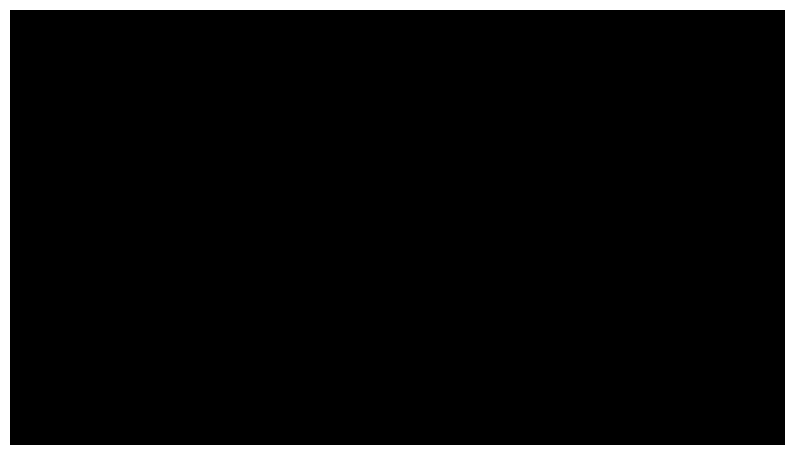

Se encontraron 0 blobs
Coches: 0


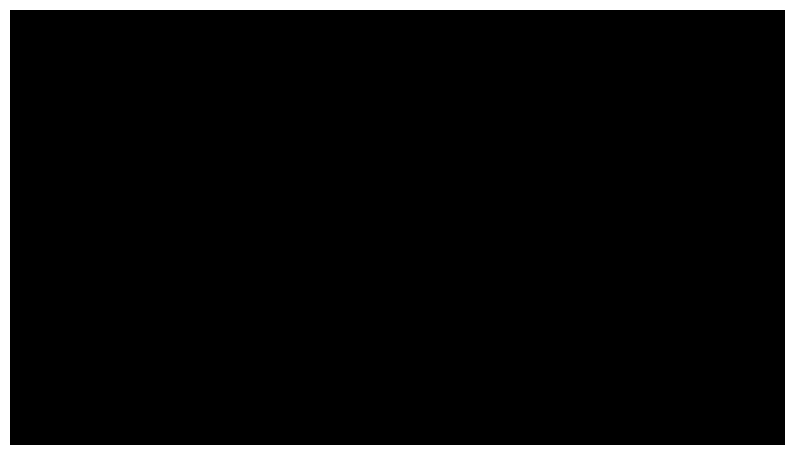

Se encontraron 0 blobs
Coches: 0


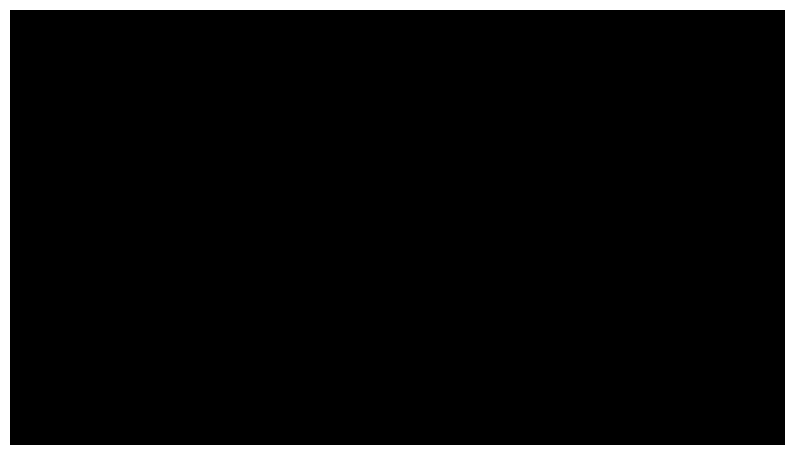

Se encontraron 0 blobs
Coches: 0


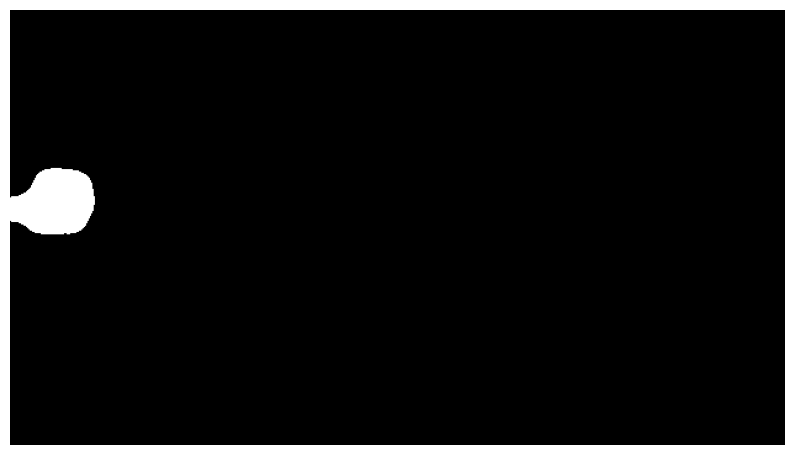

Se encontraron 0 blobs
Coches: 0


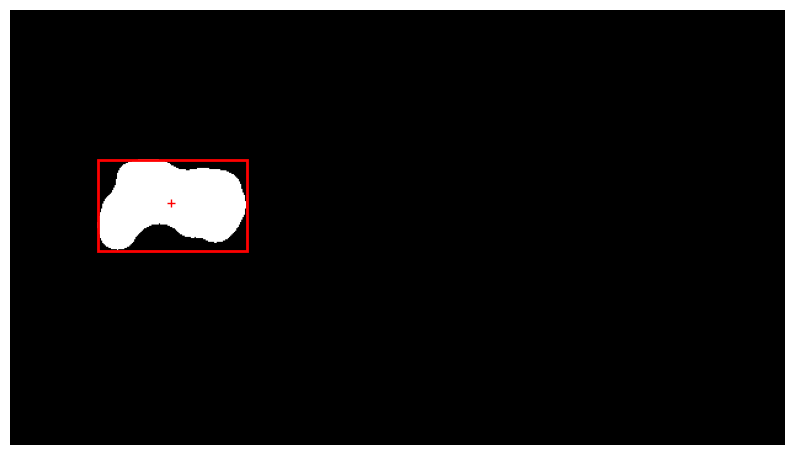

Se encontraron 1 blobs
Blob 1:
  - Área: 6308.00 píxeles
  - Centroide: (157.0, 130.4)
  - Bounding box: (122, 71, 196, 192)
Coches: 1


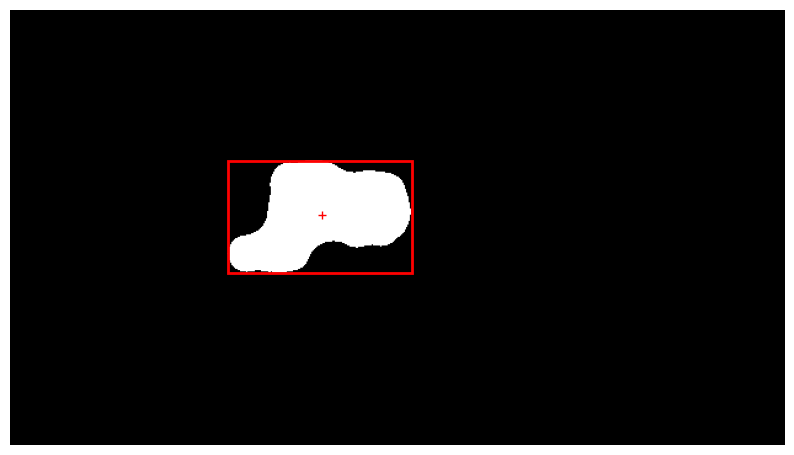

Se encontraron 1 blobs
Blob 1:
  - Área: 8587.00 píxeles
  - Centroide: (166.9, 253.3)
  - Bounding box: (123, 177, 214, 326)
Coches: 1


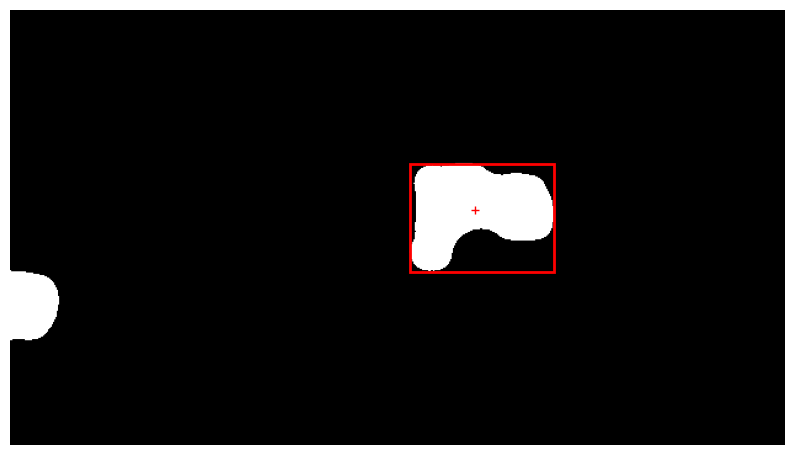

Se encontraron 1 blobs
Blob 1:
  - Área: 6773.00 píxeles
  - Centroide: (162.1, 377.5)
  - Bounding box: (125, 325, 213, 442)
Coches: 1


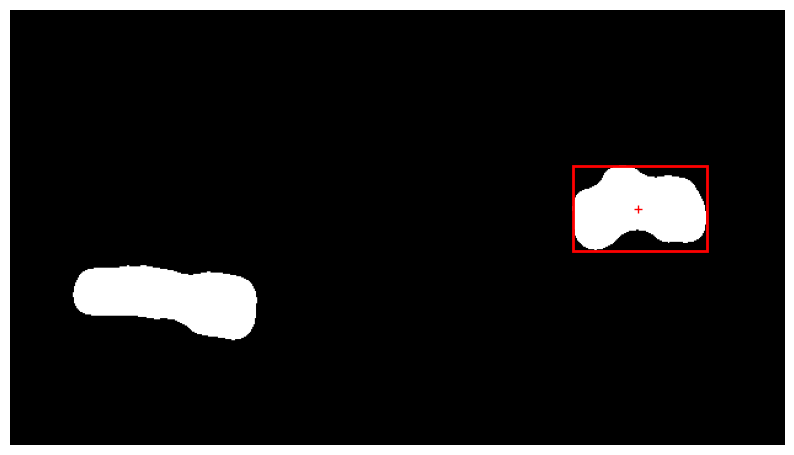

Se encontraron 1 blobs
Blob 1:
  - Área: 5353.00 píxeles
  - Centroide: (161.7, 510.2)
  - Bounding box: (127, 457, 196, 566)
Coches: 1


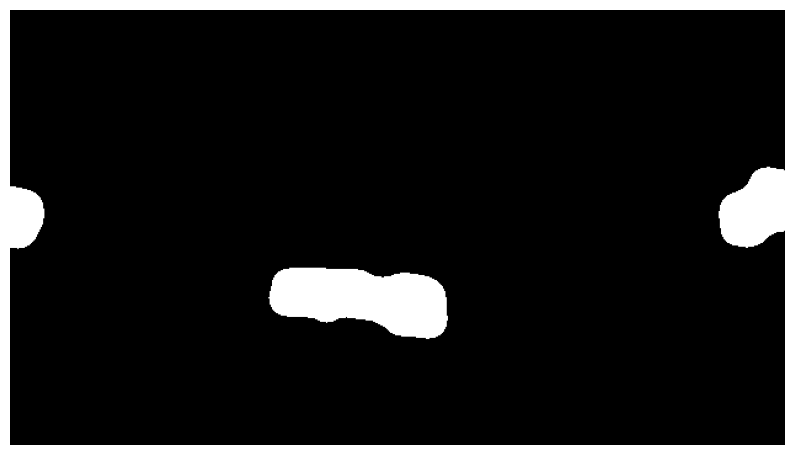

Se encontraron 0 blobs
Coches: 0


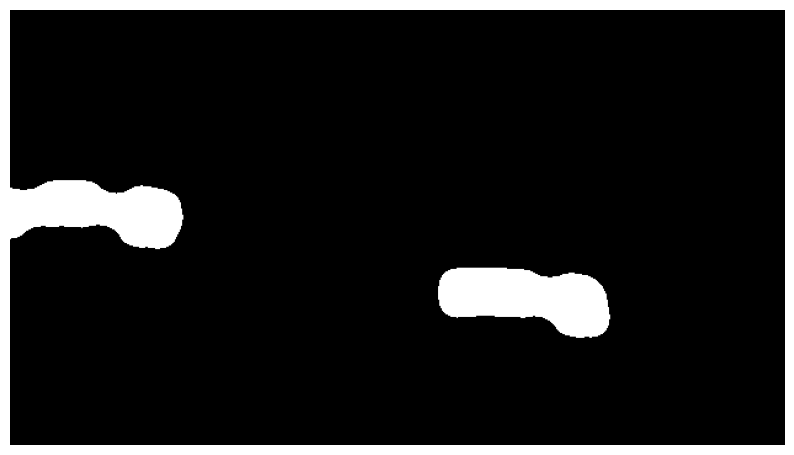

Se encontraron 0 blobs
Coches: 0


In [128]:
for i in range(len(video_dif_fondo_umbralizada_filtered)):
    mostrar_blobs(video_dif_fondo_umbralizada_filtered[i], all_blobs_filtered[i])
    print("Coches: " + str(len(all_blobs_filtered[i])))

In [129]:
def es_blob_valido2(blob):
    '''
    Versión más permisiva para detectar vehículos.
    '''
    # Obtener propiedades básicas
    area = blob['area']
    centroide_y, centroide_x = blob['centroide']
    min_row, min_col, max_row, max_col = blob['bbox']
    
    # 1. Filtro de área más amplio
    if area < 1000 or area > 20000:  # Rango más amplio
        return False
    
    # 2. Filtro de posición Y (solo carretera)
    if centroide_y < 100:  # Ajusta según la posición de la carretera
        return False
    
    # 3. Filtro de relación de aspecto más flexible
    ancho = max_col - min_col
    alto = max_row - min_row
    relacion_aspecto = max(ancho, alto) / (min(ancho, alto) + 1e-5)
    
    if relacion_aspecto > 8:  # Más permisivo con formas alargadas
        return False
    
    # 4. Tamaño mínimo en píxeles
    if ancho < 20 or alto < 20:  # Tamaño mínimo razonable
        return False
    
    return True

In [130]:
def filtrar_blobs(all_blobs):
    """Recorre todos los blobs de cada frame y almacena sólo los blobs que satisfacen es_blob_valido"""
    all_blobs_filtered = []

    for blobs in all_blobs:
        blobs_filtered = []

        for blob in blobs:
            if es_blob_valido2(blob):
                blobs_filtered.append(blob)

        all_blobs_filtered.append(blobs_filtered)

    return all_blobs_filtered

In [131]:
all_blobs_filtered = filtrar_blobs(all_blobs)

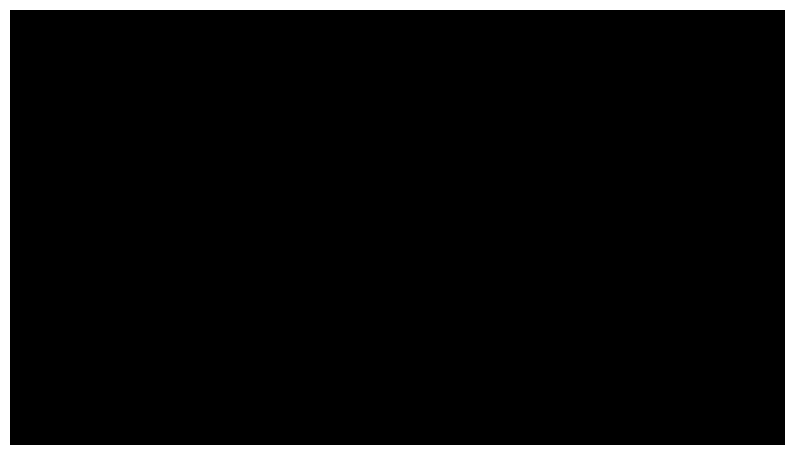

Se encontraron 0 blobs
Coches: 0


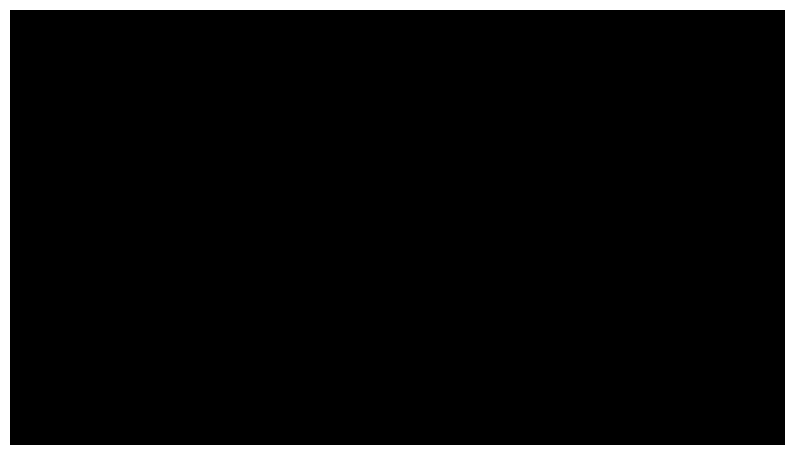

Se encontraron 0 blobs
Coches: 0


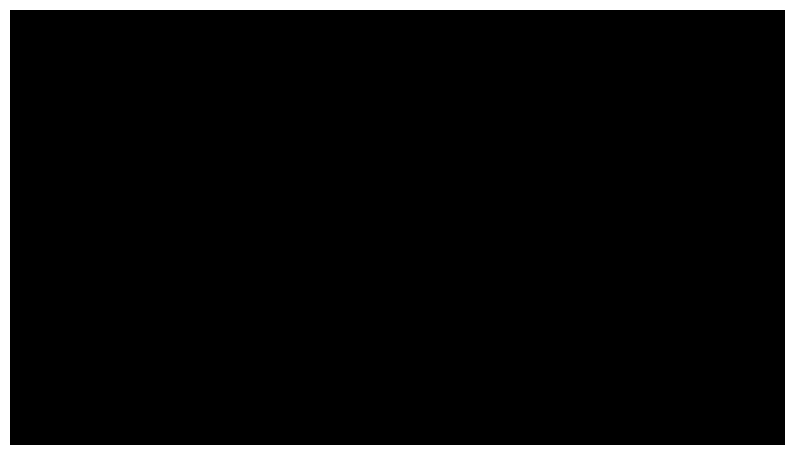

Se encontraron 0 blobs
Coches: 0


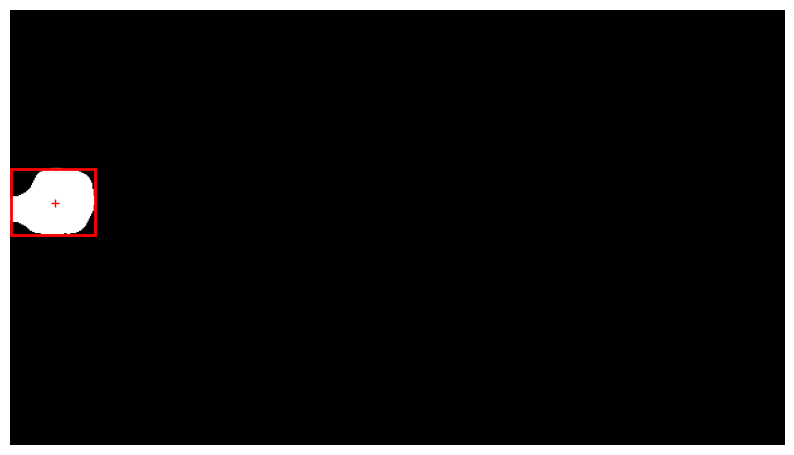

Se encontraron 1 blobs
Blob 1:
  - Área: 2872.00 píxeles
  - Centroide: (156.9, 36.3)
  - Bounding box: (129, 0, 183, 69)
Coches: 1


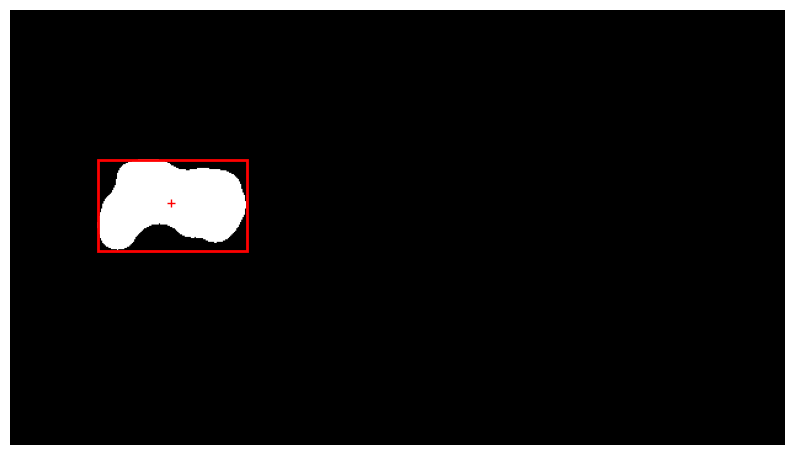

Se encontraron 1 blobs
Blob 1:
  - Área: 6308.00 píxeles
  - Centroide: (157.0, 130.4)
  - Bounding box: (122, 71, 196, 192)
Coches: 1


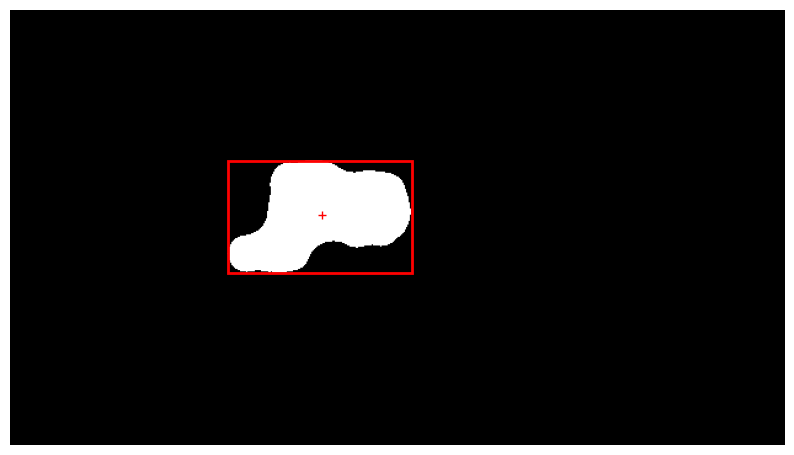

Se encontraron 1 blobs
Blob 1:
  - Área: 8587.00 píxeles
  - Centroide: (166.9, 253.3)
  - Bounding box: (123, 177, 214, 326)
Coches: 1


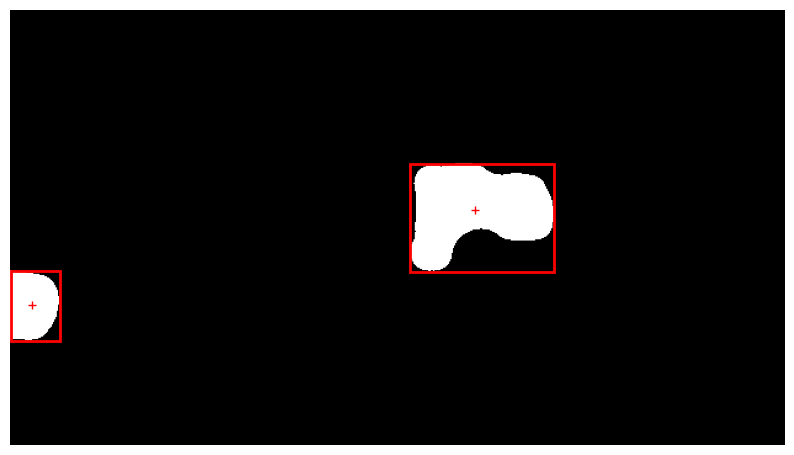

Se encontraron 2 blobs
Blob 1:
  - Área: 6773.00 píxeles
  - Centroide: (162.1, 377.5)
  - Bounding box: (125, 325, 213, 442)
Blob 2:
  - Área: 1912.00 píxeles
  - Centroide: (240.1, 17.2)
  - Bounding box: (212, 0, 269, 40)
Coches: 2


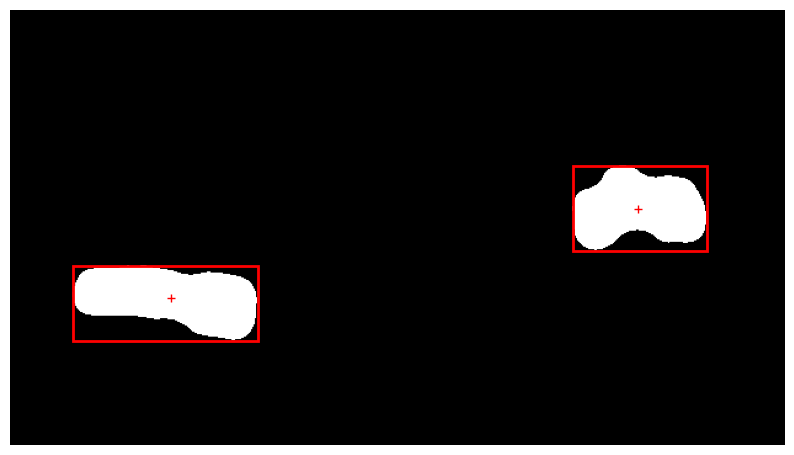

Se encontraron 2 blobs
Blob 1:
  - Área: 5353.00 píxeles
  - Centroide: (161.7, 510.2)
  - Bounding box: (127, 457, 196, 566)
Blob 2:
  - Área: 6284.00 píxeles
  - Centroide: (234.4, 130.3)
  - Bounding box: (208, 51, 269, 201)
Coches: 2


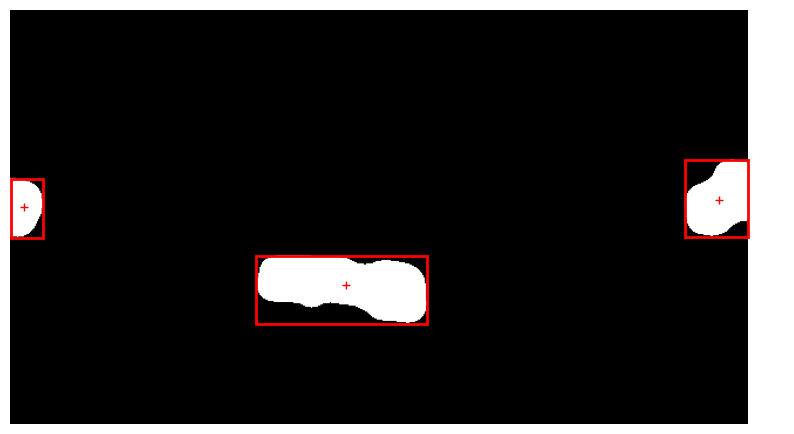

Se encontraron 3 blobs
Blob 1:
  - Área: 2631.00 píxeles
  - Centroide: (162.3, 605.1)
  - Bounding box: (128, 576, 194, 630)
Blob 2:
  - Área: 1150.00 píxeles
  - Centroide: (168.4, 11.6)
  - Bounding box: (144, 0, 195, 28)
Blob 3:
  - Área: 6057.00 píxeles
  - Centroide: (235.0, 286.3)
  - Bounding box: (210, 210, 268, 356)
Coches: 3


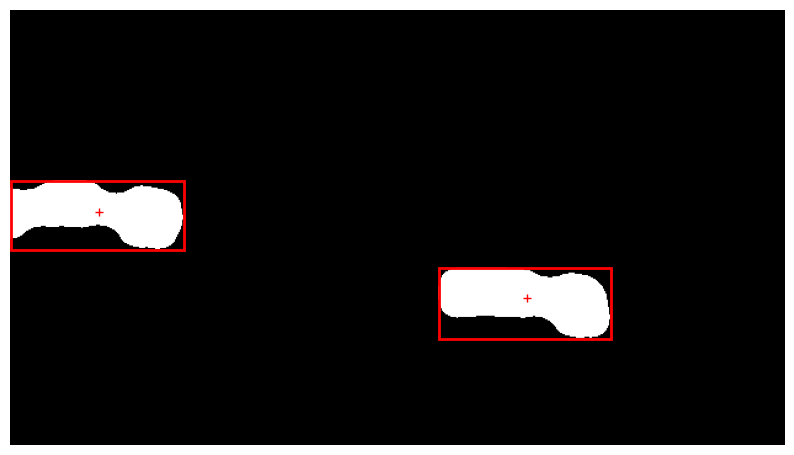

Se encontraron 2 blobs
Blob 1:
  - Área: 5390.00 píxeles
  - Centroide: (163.7, 72.2)
  - Bounding box: (139, 0, 195, 141)
Blob 2:
  - Área: 5586.00 píxeles
  - Centroide: (234.2, 420.0)
  - Bounding box: (210, 348, 267, 488)
Coches: 2


In [132]:
for i in range(len(video_dif_fondo_umbralizada_filtered)):
    mostrar_blobs(video_dif_fondo_umbralizada_filtered[i], all_blobs_filtered[i])
    print("Coches: " + str(len(all_blobs_filtered[i])))